In [1]:
from IPython.display       import SVG
from matplotlib            import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from glob                  import glob
from os                    import makedirs
from os.path               import exists, isdir

import numpy as np

from sys import version as pythonVersion
print('Python version =', pythonVersion)
from tensorflow import __version__ as tfVersion
print('Tensorflow version =', tfVersion)
from keras import __version__ as kerasVersion
print('Keras version =', kerasVersion, end='\n\n')

from tensorflow.test import is_built_with_cuda, is_gpu_available, gpu_device_name
print('\nBuilt with CUDA\t= {}\nGPU available\t= {}\nGPU device name = {}'
      .format(is_built_with_cuda(), is_gpu_available(), gpu_device_name()))
from tensorflow.python.client import device_lib
print('\nAll devices:', device_lib.list_local_devices())

from keras                 import backend as K
from keras.callbacks       import ProgbarLogger
from keras.initializers    import VarianceScaling
from keras.layers          import Activation, BatchNormalization, Bidirectional, concatenate, \
                                  Conv2D, Dense, Input, LSTM, MaxPool2D, Reshape
from keras.losses          import mean_squared_error
from keras.models          import load_model, Model
from keras.utils.vis_utils import model_to_dot

from librosa               import midi_to_hz
from sklearn.metrics       import auc, roc_curve
from sklearn.preprocessing import binarize

from magenta.music.sequences_lib                        import pianoroll_to_note_sequence
from magenta.models.onsets_frames_transcription.metrics import sequence_to_valued_intervals
from mir_eval.transcription                             import precision_recall_f1_overlap as Overlap
from mir_eval.transcription_velocity                    import precision_recall_f1_overlap as OverlapVolumes

Python version = 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
Tensorflow version = 2.4.0
Keras version = 2.4.3

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.

Built with CUDA	= True
GPU available	= True
GPU device name = /device:GPU:0

All devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1283227987706384664
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3129973147
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15535348630916562096
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
dataFolder, melsMinMin, melsMinMax, melsMeanMin, melsMeanMax, melsMaxMin, melsMaxMax \
    = 'Maestro/5-20 seconds', -87, -85, -31, -30, 38, 41

melsTrain, melsVal = map(lambda split: np.load('{}/Mels {}.npy'.format(dataFolder, split), 'r'), ['train', 'validation'])
print('{} train, {} validation samples,'.format(len(melsTrain), len(melsVal)), end='\t')

melsTrainMin,  melsValMin  = map(np.min,  [melsTrain, melsVal])
melsTrainMean, melsValMean = map(np.mean, [melsTrain, melsVal])
melsTrainMax,  melsValMax  = map(np.max,  [melsTrain, melsVal])
assert  min(melsTrainMin,  melsValMin)  > melsMinMin  and max(melsTrainMin,  melsValMin)  < melsMinMax  \
    and min(melsTrainMean, melsValMean) > melsMeanMin and max(melsTrainMean, melsValMean) < melsMeanMax \
    and min(melsTrainMax,  melsValMax)  > melsMaxMin  and max(melsTrainMax,  melsValMax)  < melsMaxMax, \
    'Wrong mels decibels range'
print('Mels decibels in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(
    min(melsTrainMin, melsValMin), np.mean([melsTrainMean, melsValMean]), max(melsTrainMax, melsValMax)))

28346 train, 3088 validation samples,	Mels decibels in range [-87 ... -31 ... 40]


# RNN Model

My previous model performed well on __*MAPS*__ dataset, but resulted in much lower accuracy on new larger, more natural, and more complicated __*MAESTRO*__ dataset.  It turned out, that just simple fully-connected network produced similar result.  It probably makes sence, as it is written in https://arxiv.org/pdf/1810.12247.pdf, Page 5, Section 4 "Piano Transcription":

`In general, we found that the best ways to get higher performance with the larger dataset were to make the model larger and simpler.`

So, I based my model on Google "Onsets and Frames: Dual-Objective Piano Transcription".<br>From https://arxiv.org/pdf/1710.11153.pdf, Page 3, Figure 1 "Diagram of Network Architecture":

![](https://magenta.tensorflow.org/assets/onsets_frames/networkstack9.png 'Architecture')
![](https://images.deepai.org/converted-papers/1906.08512/x1.png 'Architecture')

I blindly coppied those model parameters, except:

1. Batch normalization is used wherever possible (everywhere except LSTM layer and the last fully-connected layer).
2. Dropout is not required at all, because there is no sign of overfitting.
3. It was impossible to keep the recommended batch size of 8 on my machine, so I reduced it to 4.

# Onsets RNN subnetwork

From https://arxiv.org/pdf/1710.11153.pdf, Page 2, Section 3 "Model Configuration":

`The onset detector is composed of the acoustic model, followed by a bidirectional LSTM ... with 128 units in both the forward and backward directions, followed by a fully connected sigmoid layer with 88 outputs for representing the probability of an onset for each of the 88 piano keys.`

Acoustic convolutional stack is taken from https://arxiv.org/pdf/1612.05153.pdf, Page 5, Section 5 "State of the Art Models", Table 4 "Model Architectures":

_         |     DNN     |    ConvNet   |   AllConv
:-------- |:----------: | :----------: | :---------:
          |Input 229    | Input 5x229  | Input 5x229
          |Dropout 0.1  | Conv 32x3x3  | Conv 32x3x3
          |Dense 512    | Conv 32x3x3  | Conv 32x3x3
          |BatchNorm    | BatchNorm    | BatchNorm
          |Dropout 0.25 | MaxPool 1x2  | MaxPool 1x2
          |Dense 512    | Dropout 0.25 | Dropout 0.25
          |BatchNorm    | Conv 64x3x3  | Conv 32x1x3
          |Dropout 0.25 | MaxPool 1x2  | BatchNorm
          |Dense 512    | Dropout 0.25 | Conv 32x1x3
          |BatchNorm    | Dense 512    | BatchNorm
          |Dropout 0.25 | Dropout 0.5  | MaxPool 1x2
          |Dense 88     | Dense 88     | Dropout 0.25
          |_            |_             | Conv 64x1x25
          |_            |_             | BatchNorm
          |_            |_             | Conv 128x1x25
          |_            |_             | BatchNorm
          |_            |_             | Dropout 0.5
          |_            |_             | Conv 88x1x1
          |_            |_             | BatchNorm
          |_            |_             | AvgPool 1x6
          |_            |_             | Sigmoid
\# Params | 691288      | 1877880      | 284544

We are interested in ConvNet, which is:

-|-|-|-|-|-|-|-|-|-|-|-| \# Params
---|---|---|---|---|---|---|---|---|---|---|---|---
 | Input 5x229 | --> | Conv 32x3x3 | --> | Conv 32x3x3 | --> | BatchNorm | --> | MaxPool 1x2 | --> | Dropout 0.25 | -->
--> | Conv 64x3x3 | --> | MaxPool 1x2 | --> | Dropout 0.25 | --> | Dense 512 | --> | Dropout 0.5 | --> | Dense 88 | 1877880

In our case there are 625 + 1 frames (20 seconds), there is bidirectional __*LSTM*__ layer in between the last two fully-connected layers, batch normalization is heavily used, dropout is not required, and remaining parameters are from https://arxiv.org/pdf/1810.12247.pdf (also, from https://github.com/tensorflow/magenta/blob/master/magenta/models/onsets_frames_transcription/model.py ):

Page 5, Section 4 "Piano Transcription":

1. `... increased the size of the bidirectional LSTM layers from 128 to 256 units,`

2. `changed the number of filters in the convolutional layers from 32/32/64 to 48/48/96,`

3. `and increased the units in the fully connected layer from 512 to 768.`

So, ConvNet simplifies to:

-|-|-|-|-|-|-|-|-|-|-|-|-
---|---|---|---|---|---|---|---|---|---|---|---|---
Input 626x229 | --> | Conv 48x3x3 | --> | BatchNorm | --> | Conv 48x3x3 | --> | BatchNorm | --> | MaxPool 1x2 | -->
Conv 96x3x3 | --> | BatchNorm | --> | MaxPool 1x2 | --> | Dense 768 | --> | BatchNorm | --> | Bidir LSTM 256 | --> | Dense 88

In [3]:
def AcousticModel(withLstm):
    inputs = Input(shape=(melsVal.shape[1], melsVal.shape[2]))
    
    BnRelu = lambda x: Activation('relu')(BatchNormalization(scale=False)(x))
    ConvBnRelu = lambda n: lambda x: BnRelu(Conv2D(n, 3, padding='same', use_bias=False,
                                                   kernel_initializer=VarianceScaling())(x)) # (2, 'fan_avg', 'uniform')
    outputs = MaxPool2D((1, 2))(ConvBnRelu(96)(MaxPool2D((1, 2))(ConvBnRelu(48)(
        ConvBnRelu(48)(Reshape((melsVal.shape[1], melsVal.shape[2], 1))(inputs))))))

    outputs = BnRelu(Dense(768, use_bias=False, kernel_initializer=VarianceScaling())( # (2, 'fan_avg', 'uniform')
        # Flatten while preserving batch and time dimensions:
        Reshape((K.int_shape(outputs)[1], K.int_shape(outputs)[2] * K.int_shape(outputs)[3]))(outputs)))
    
    if withLstm: outputs = Bidirectional(LSTM(256, kernel_initializer=VarianceScaling(), # (2)
                                              return_sequences=True))(outputs)
    # Default Xavier Glorot & Yoshua Bengio initializer because of Sigmoid activation instead of ReLU:
    return Model(inputs, Dense(88, activation='sigmoid')(outputs))

# Frame-Based Accuracy Metric (stricter than F1-score)
Standard accuracy is not representative, it would be almost 50% immediately at the beginning, and would obviously rise up to 99% very quickly.  F1-score is better, but there is stricter accuracy metric, taken from http://c4dm.eecs.qmul.ac.uk/ismir15-amt-tutorial/AMT_tutorial_ISMIR_2015.pdf<br>Page 50, Slide 100, Evaluation Metric 3 [Dixon, 2000]:
### $$Acc = \frac{\sum_{n}Ntp[n]}{\sum_{n}Nfp[n] + \sum_{n}Nfn[n] + \sum_{n}Ntp[n]} =$$
### $$= \frac{tp}{fp + fn + tp} = \frac{tp}{(pp-tp) + (rp-tp) + tp} = \frac{tp}{pp + rp - tp}$$

In [4]:
def Dixon(yTrue, yPred):
    # true (correct) positives, predicted positives = tp + fp, real (ground-truth) positives = tp + fn
    tp, pp, rp = K.sum(yTrue * K.round(yPred)), K.sum(K.round(yPred)), K.sum(yTrue)
    return 1. if pp == 0 and rp == 0 else tp / (pp + rp - tp + K.epsilon())

modelFolder = 'Models' # HDF5-files
if not isdir(modelFolder): makedirs(modelFolder)

def GetModel(name, accs, accTrain, accVal, xVal, yVal, evalBatchSize, withLstm, loss):
    if exists('{}/Training {} Model {:.2f} {:.2f}.hdf5'.format(modelFolder, name, accTrain * 100, accVal * 100)) \
            and exists('{}/Training {} History {:.2f} {:.2f}.npy'.format(modelFolder, name, accTrain * 100, accVal * 100)):
        hist = np.load('{}/Training {} History {:.2f} {:.2f}.npy'.format(modelFolder, name, accTrain * 100, accVal * 100)
                       , allow_pickle=True
                      )[0]
        print('Loading pre-trained {} model...'.format(name))
        model = load_model('{}/Training {} Model {:.2f} {:.2f}.hdf5'.format(modelFolder, name, accTrain * 100, accVal * 100),
                           compile=False) # Otherwise TypeError: '<' not supported between instances of 'function' and 'str'
        model.compile('Adam', loss, list(accs.values())) # But have to compile manually
        print('Spent {} epochs, current validation loss and {} are:'.format(len(hist['loss']), list(accs.keys())[0]))
        print(model.evaluate(xVal, yVal, evalBatchSize, 1))
        return model, hist

    elif not exists('{}/Training {} Model {:.2f} {:.2f}.hdf5'.format(modelFolder, name, accTrain * 100, accVal * 100)) \
            and not exists('{}/Training {} History {:.2f} {:.2f}.npy'.format(modelFolder, name, accTrain * 100, accVal * 100)):
        model = AcousticModel(withLstm)
        model.compile('Adam', loss, list(accs.values()))
        return model, None
    
    else: assert False, 'Either provide both training model & training history files, or none'

PlotModel = lambda: SVG(model_to_dot(model, True, show_layer_names=False, dpi=72).create(format='svg'))

Loading pre-trained Onsets model...
Instructions for updating:
Colocations handled automatically by placer.
Spent 13 epochs, current validation loss and Dixon are:
3088/3088 [==============================] - 65s 21ms/step
[0.6578747963658269, 0.6210420026680349]


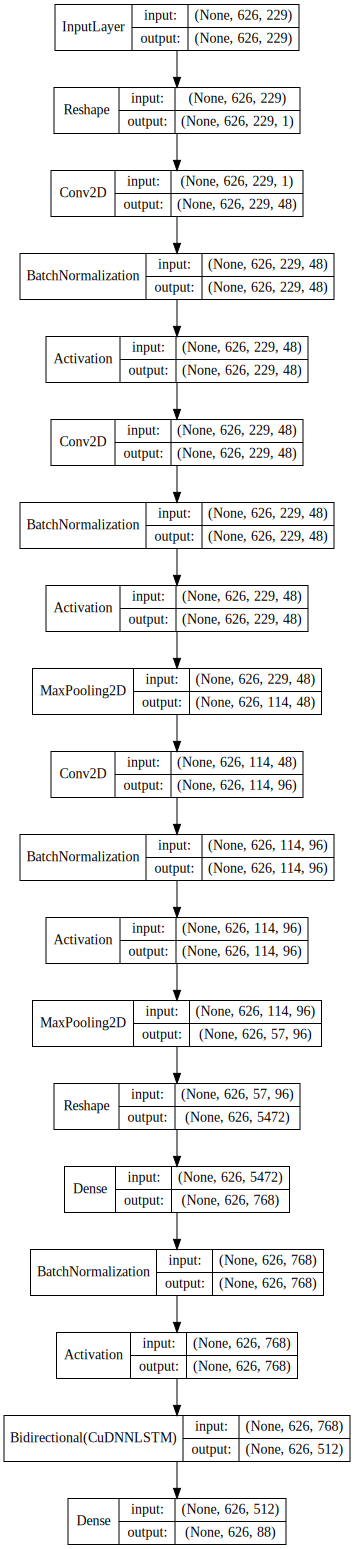

In [5]:
lossMetric = 'binary_crossentropy' # categorical_crossentropy does not work anymore

onsetsTrain, onsetsVal = map(lambda split: np.load('{}/Onsets {}.npy'.format(dataFolder, split), 'r'),
                             ['train', 'validation'])
model, hist = GetModel('Onsets', {'Dixon': Dixon}, 67.42 / 100, 62.69 / 100, melsVal, onsetsVal, 32, True, lossMetric)
PlotModel()

# 1. Training & Validation
From https://arxiv.org/pdf/1710.11153.pdf (also from https://github.com/tensorflow/magenta/blob/master/magenta/models/onsets_frames_transcription/model.py ):

Page 4, Section 4 "Experiments":

`... batch size of 8 ...` __*In our case it is 4 for onsets, offsets, and frames subnetworks, and 8 for volumes CNN*__

`... Adam optimizer ...`

# Keras Backend

We use __*CuDNNLSTM*__ as recurrent layer, and it supports only __*Tensorflow*__ backend, so, it is impossible to use __*CNTK*__.

In [6]:
def TrainAndSave(xTrain, xVal, yTrain, yVal, batchSize, name, acc):
    global hist
    
#    class ValDixon_ProgbarLogger(ProgbarLogger):
#        def __init__(self):
#            super().__init__()
#            self.verbose = 1 # ignore the argument from fit()

#        def on_train_begin(self, logs=None):
#            self.epochs = self.params['epochs']
#            self.params['metrics'].remove('val_loss')

    if not hist: hist = model.fit(xTrain, yTrain, batchSize, validation_data=(xVal, yVal)).history
    loss = np.inf
    while loss > hist['loss'][-1]:
        loss, newHist = hist['loss'][-1], model.fit(xTrain, yTrain, batchSize,
#            verbose=0, callbacks=[ValDixon_ProgbarLogger()],
            validation_data=(xVal, yVal)).history
        hist = {key: hist[key] + val for key, val in newHist.items()}
        model.save('{}/Training {} Model {:.2f} {:.2f}.hdf5'.format(
            modelFolder, name, hist[acc][-1] * 100, hist['val_' + acc][-1] * 100))
        np.save('{}/Training {} History {:.2f} {:.2f}'.format(
            modelFolder, name, hist[acc][-1] * 100, hist['val_' + acc][-1] * 100), [hist])

In [9]:
TrainAndSave(melsTrain, melsVal, onsetsTrain, onsetsVal, 4, 'Onsets', 'Dixon')

Train on 28346 samples, validate on 3088 samples
Epoch 1/1
28346/28346 [==============================] - 2227s 79ms/step - loss: 0.7278 - Dixon: 0.5494 - val_loss: 0.6356 - val_Dixon: 0.5813
Epoch 1/1
28346/28346 [==============================] - 2223s 78ms/step - loss: 0.6367 - Dixon: 0.6070 - val_Dixon: 0.6242
Epoch 1/1
28346/28346 [==============================] - 2221s 78ms/step - loss: 0.6076 - Dixon: 0.6284 - val_Dixon: 0.6423
Epoch 1/1
28346/28346 [==============================] - 2219s 78ms/step - loss: 0.5880 - Dixon: 0.6398 - val_Dixon: 0.6400
Epoch 1/1
28346/28346 [==============================] - 2225s 78ms/step - loss: 0.5724 - Dixon: 0.6473 - val_Dixon: 0.6465
Epoch 1/1
28346/28346 [==============================] - 2237s 79ms/step - loss: 0.5593 - Dixon: 0.6525 - val_Dixon: 0.6407
Epoch 1/1
28346/28346 [==============================] - 2235s 79ms/step - loss: 0.5479 - Dixon: 0.6574 - val_Dixon: 0.6477
Epoch 1/1
28346/28346 [==============================] - 2236s 7

In [8]:
def HistoryGraph(acc, title):
    plt.figure(figsize=(16, 16))

    ax1 = plt.subplot(2, 1, 1)
    plt.plot(range(1, len(hist['loss']) + 1), hist[         acc], color='#FF8000', linewidth=3, label='Training')
    plt.plot(range(1, len(hist['loss']) + 1), hist['val_' + acc], color='r', linewidth=3, label='Validation')
    plt.ylim(min(hist[acc][:-1] + hist['val_' + acc][:-1]), max(hist[acc] + hist['val_' + acc]))
    plt.title(title)
    
    ax2 = plt.subplot(2, 1, 2)
    plt.plot(range(1, len(hist['loss']) + 1), hist[    'loss'], color='g', linewidth=3, label='Training')
    plt.plot(range(1, len(hist['loss']) + 1), hist['val_loss'], color='b', linewidth=3, label='Validation')
    plt.ylim(min(hist['loss'] + hist['val_loss']), max(hist['loss'][:-1] + hist['val_loss'][:-1]))
    plt.title('Loss history')
    
    minValLoss, maxValAcc = min(hist['val_loss']), max(hist['val_' + acc])
    lossInd, accInd = hist['val_loss'].index(minValLoss), hist['val_' + acc].index(maxValAcc)
    accTrain, accVal = hist[acc][lossInd], hist['val_' + acc][lossInd]
    for a in [ax1, ax2]:
        a.vlines(lossInd + 1, 0, 12, 'b', linewidth=3,
                   label='Min validation loss, validation {} = {:.2%}'.format(acc, hist['val_' + acc][lossInd]))
        a.vlines(accInd + 1, 0, 12, 'r', linewidth=3,
                   label=                 'Max validation {} = {:.2%}'.format(acc, maxValAcc))
        a.legend()
        a.set_xlabel('Epoch')
        a.set_xlim(1, len(hist['loss']))
        a.grid()
    
    print('Maximum validation {0} = {1:.2%}, but the chosen ones are at the minimum validation loss:\n'
          'Train = {2:.2%}, Validation = {3:.2%}'.format(acc, maxValAcc, accTrain, accVal))
    return accTrain, accVal

Maximum validation Dixon = 64.77%, but the chosen ones are at the minimum validation loss:
Train = 63.98%, Validation = 64.00%


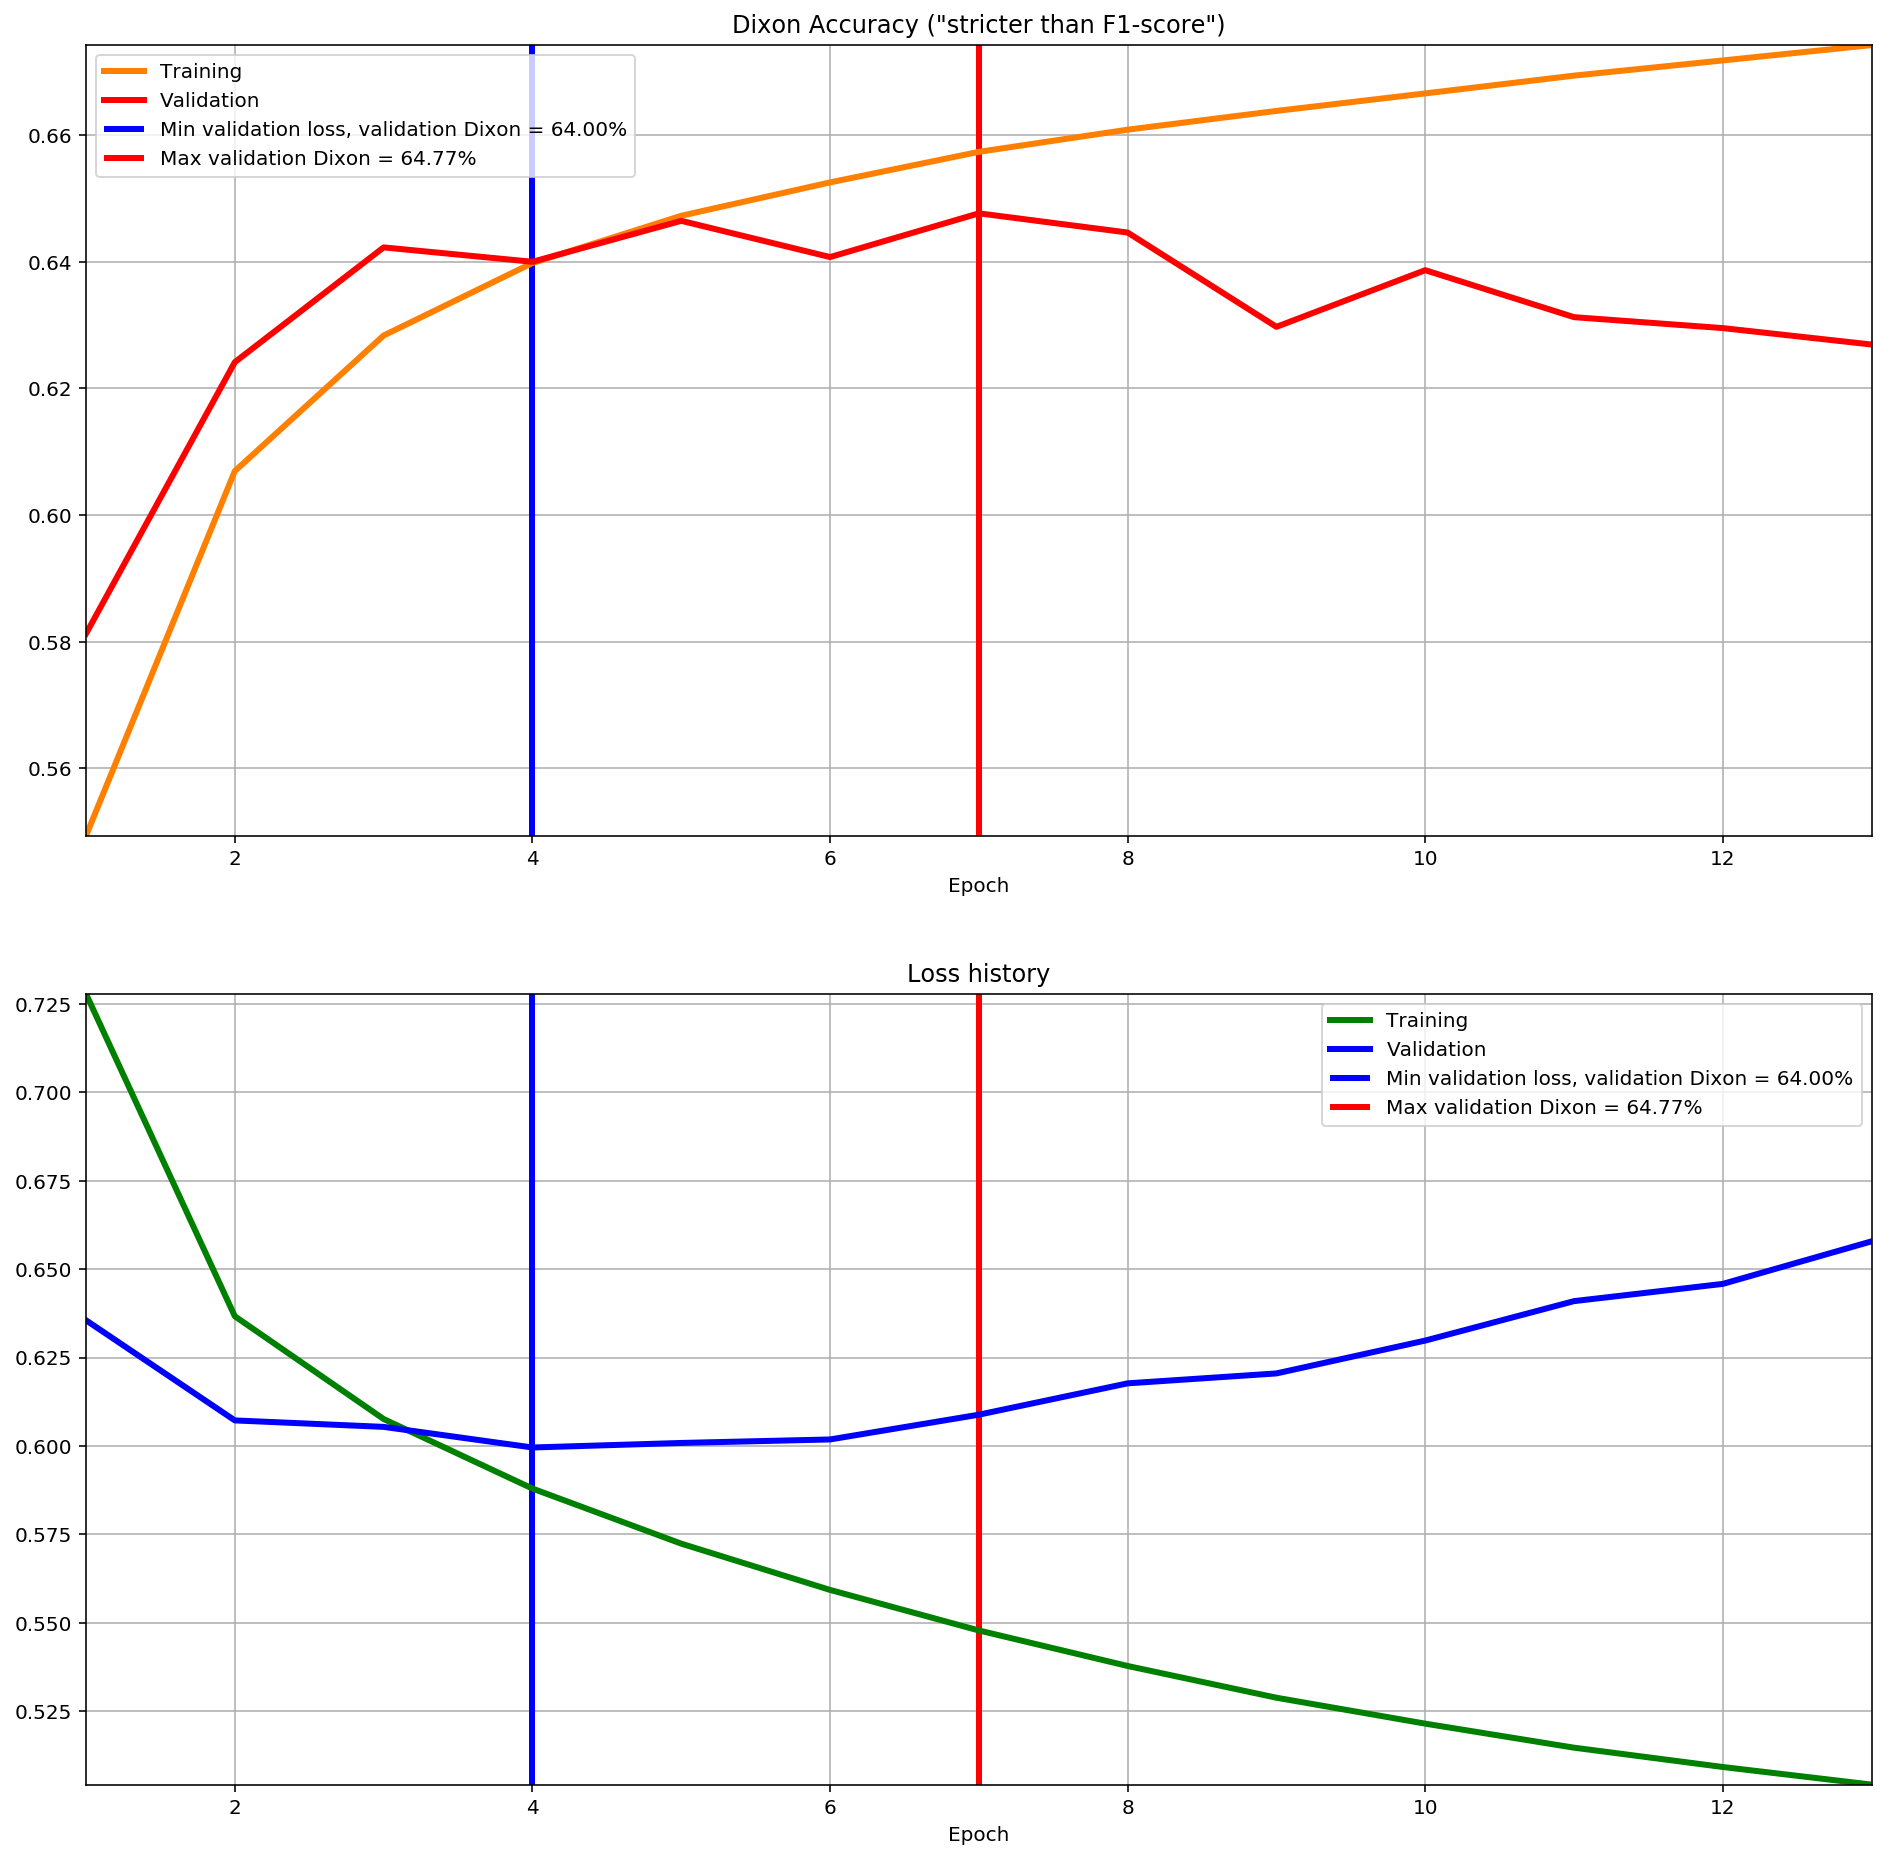

In [8]:
accTrain, accVal = HistoryGraph('Dixon', 'Dixon Accuracy ("stricter than F1-score")')

In [9]:
onsetsModel = GetModel('Onsets', {'Dixon': Dixon}, accTrain, accVal, melsVal, onsetsVal, 32, True, lossMetric)[0]
onsetsPredTrain, onsetsPredVal = map(lambda x: onsetsModel.predict(x, 32, 1), [melsTrain, melsVal])
'{} {:.3f} {}    {} {:.3f} {}'.format(onsetsPredTrain.min(), onsetsPredTrain.mean(), onsetsPredTrain.max(),
                                      onsetsPredVal.min(),   onsetsPredVal.mean(),   onsetsPredVal.max())

Loading pre-trained Onsets model...
Spent 4 epochs, current validation loss and Dixon are:
3088/3088 [==============================] - 61s 20ms/step
[0.5995902998150939, 0.6343586000136143]
3088/3088 [==============================] - 92s 30ms/step


'0.0 0.009 0.9999998807907104    0.0 0.009 0.9999998807907104'

# Offsets RNN subnetwork
From https://arxiv.org/pdf/1810.12247.pdf, Page 5, Section 4 "Piano Transcription":

`... adding an offset detection head, inspired by Kelz et al. (2018).  The offset head feeds into the frame detector but is not directly used during decoding.  The offset labels are defined to be the 32ms following the end of each note.`

Loading pre-trained Offsets model...
Spent 18 epochs, current validation loss and Dixon are:
3088/3088 [==============================] - 69s 22ms/step
[1.0978233425110733, 0.3843937315471432]


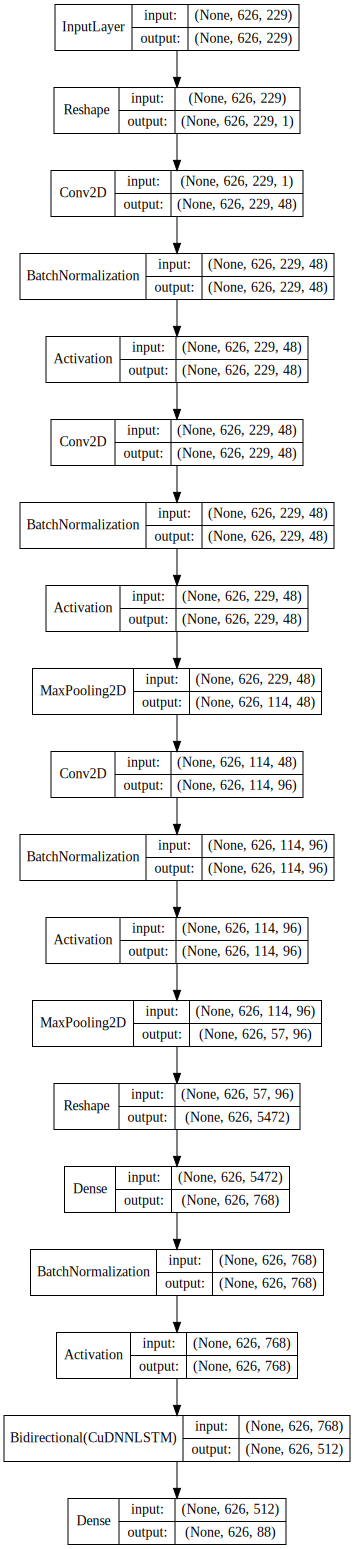

In [10]:
offsetsTrain, offsetsVal = map(lambda split: np.load('{}/Offsets {}.npy'.format(dataFolder, split), 'r'),
                               ['train', 'validation'])
model, hist = GetModel('Offsets', {'Dixon': Dixon}, 45.37 / 100, 38.16 / 100, melsVal, offsetsVal, 32, True, lossMetric)
PlotModel()

In [198]:
TrainAndSave(melsTrain, melsVal, offsetsTrain, offsetsVal, 4, 'Offsets', 'Dixon')

Train on 28346 samples, validate on 3088 samples
Epoch 1/1
28346/28346 [==============================] - 2339s 83ms/step - loss: 1.2692 - Dixon: 0.2491 - val_loss: 1.1478 - val_Dixon: 0.2881
Epoch 1/1
28346/28346 [==============================] - 2268s 80ms/step - loss: 1.0976 - Dixon: 0.3359 - val_Dixon: 0.3595
Epoch 1/1
28346/28346 [==============================] - 2231s 79ms/step - loss: 1.0377 - Dixon: 0.3810 - val_Dixon: 0.3819
Epoch 1/1
28346/28346 [==============================] - 2224s 78ms/step - loss: 1.0009 - Dixon: 0.4049 - val_Dixon: 0.3759
Epoch 1/1
28346/28346 [==============================] - 2234s 79ms/step - loss: 0.9750 - Dixon: 0.4174 - val_Dixon: 0.3941
Epoch 1/1
28346/28346 [==============================] - 2248s 79ms/step - loss: 0.9543 - Dixon: 0.4257 - val_Dixon: 0.4135
Epoch 1/1
28346/28346 [==============================] - 2247s 79ms/step - loss: 0.9368 - Dixon: 0.4321 - val_Dixon: 0.3953
Epoch 1/1
28346/28346 [==============================] - 2221s 7

Maximum validation Dixon = 41.35%, but the chosen ones are at the minimum validation loss:
Train = 43.21%, Validation = 39.53%


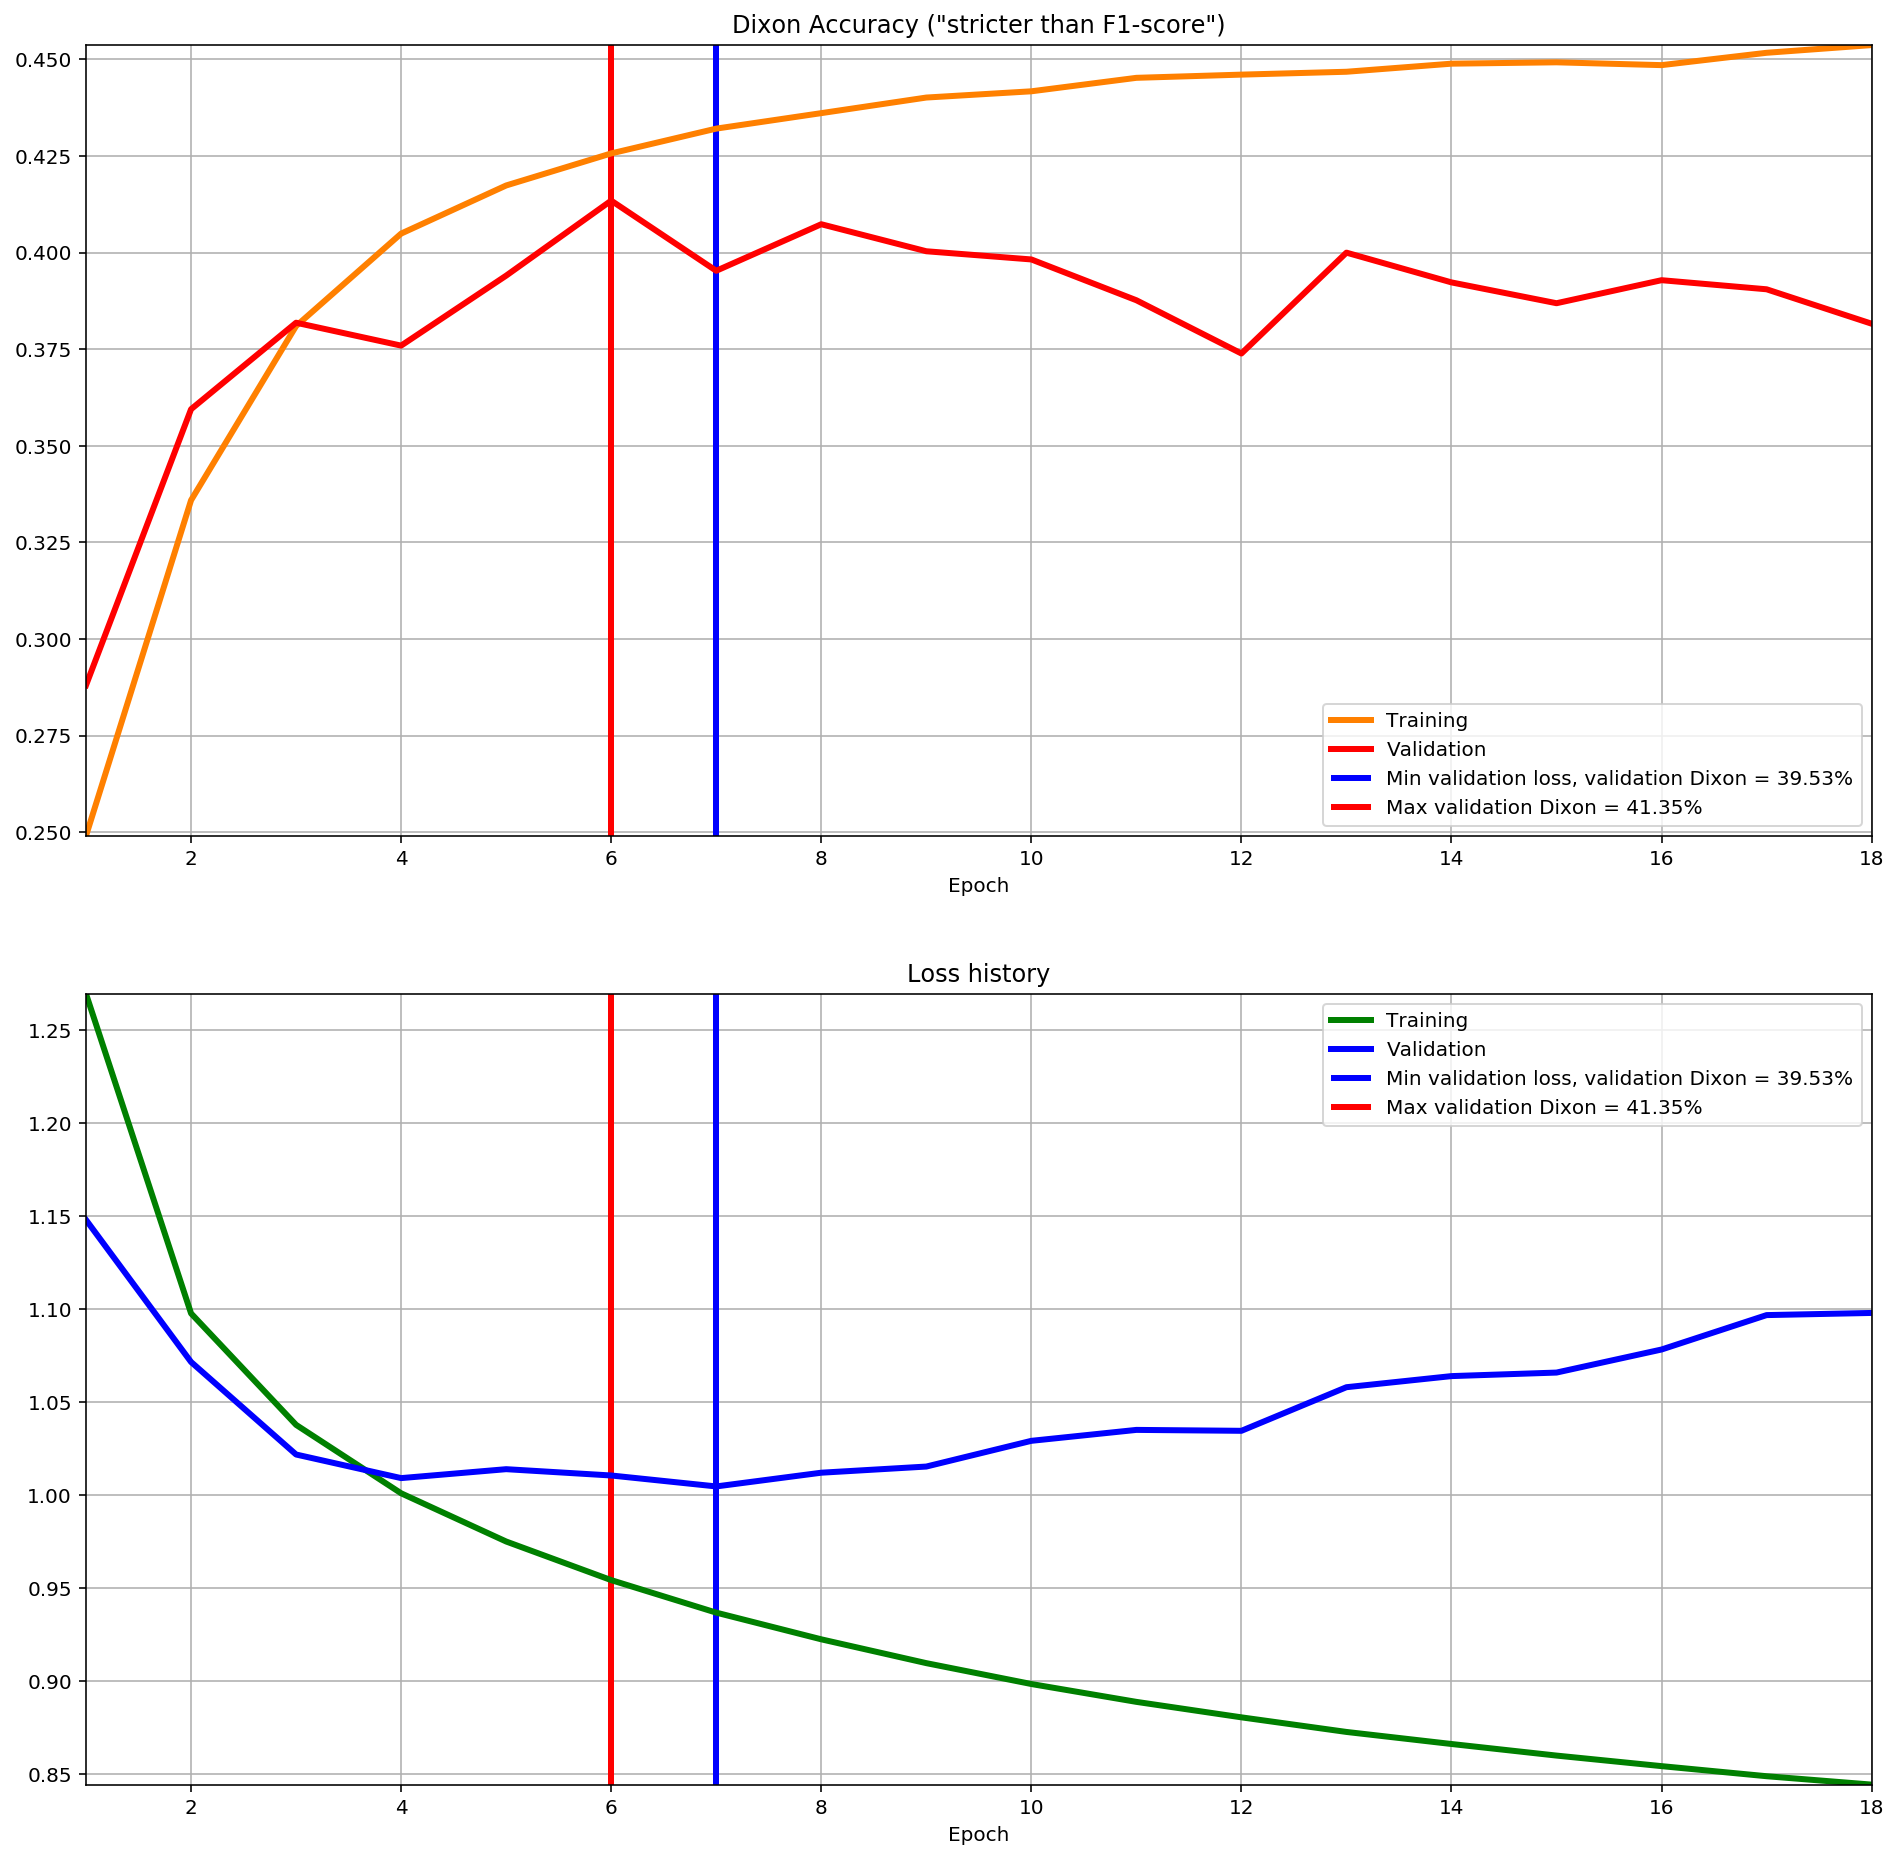

In [11]:
accTrain, accVal = HistoryGraph('Dixon', 'Dixon Accuracy ("stricter than F1-score")')

In [12]:
offsetsModel = GetModel('Offsets', {'Dixon': Dixon}, accTrain, accVal, melsVal, onsetsVal, 32, True, lossMetric)[0]
offsetsPredTrain, offsetsPredVal = map(lambda x: offsetsModel.predict(x, 32, 1), [melsTrain, melsVal])
'{} {:.3f} {:.1e}    {} {:.3f} {:.1e}'.format(offsetsPredTrain.min(), offsetsPredTrain.mean(), offsetsPredTrain.max(),
                                              offsetsPredVal.min(),   offsetsPredVal.mean(),   offsetsPredVal.max())

Loading pre-trained Offsets model...
Spent 7 epochs, current validation loss and Dixon are:
3088/3088 [==============================] - 65s 21ms/step
[1.8115392867765279, 0.12489675734327248]
3088/3088 [==============================] - 61s 20ms/step


'0.0 0.013 1.0e+00    0.0 0.013 1.0e+00'

# Frames RNN combined network
From https://arxiv.org/pdf/1710.11153.pdf, Page 2, Section 3 "Model Configuration":

`The frame activation detector is composed of a separate acoustic model, followed by a fully connected sigmoid layer with 88 outputs.  Its output is concatenated together with the output of the onset detector and followed by a bidirectional LSTM with 128 units in both the forward and backward directions.  Finally, the output of that LSTM is followed by a fully connected sigmoid layer with 88 outputs.  During inference, we use a threshold of 0.5 to determine whether the onset detector or frame detector is active.`

Page 3:

`Our loss function is the sum of two cross-entropy losses: one from the onset side and one from the note side.`
$$L_{total} = L_{onset} + L_{frame}$$


From https://arxiv.org/pdf/1810.12247.pdf, Page 5, Section 4 "Piano Transcription":

`We also stopped gradient propagation into the onset subnetwork from the frame network...`

Loading pre-trained Actives model...
Spent 24 epochs, current validation loss and Dixon are:
3088/3088 [==============================] - 78s 25ms/step
[8.84618278365061, 0.9258684735224036]


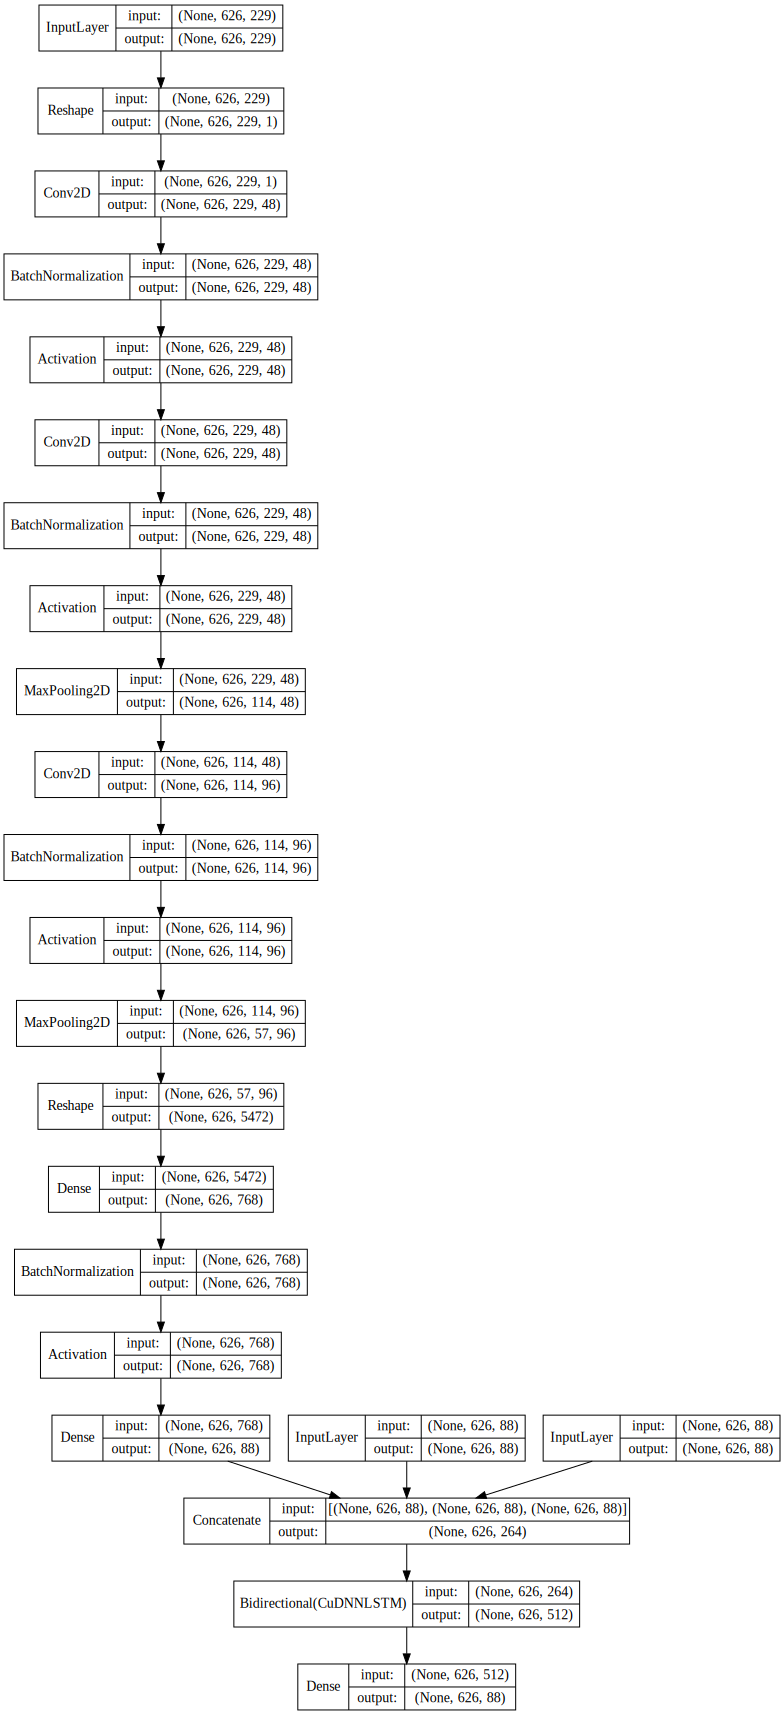

In [13]:
activesTrain, activesVal = map(lambda split: np.load('{}/Actives {}.npy'.format(dataFolder, split), 'r'),
                               ['train', 'validation'])
model, hist = GetModel('Actives', {'Dixon': Dixon}, 91.11 / 100, 80.48 / 100,
                       [melsVal, onsetsVal, offsetsVal], activesVal, 32, False, lossMetric)
if not hist:
    onsetsIn, offsetsIn = Input(shape=( onsetsVal.shape[1],  onsetsVal.shape[2])), \
                          Input(shape=(offsetsVal.shape[1], offsetsVal.shape[2]))
    # Default Xavier Glorot & Yoshua Bengio initializer because of Sigmoid activation instead of ReLU:
    model = Model([model.input, onsetsIn, offsetsIn], Dense(activesVal.shape[2], activation='sigmoid')(
        Bidirectional(CuDNNLSTM(256, kernel_initializer=VarianceScaling(), return_sequences=True))(
            concatenate([model.output, onsetsIn, offsetsIn]))))
    model.compile('Adam', lossMetric, [Dixon])
    
PlotModel()

In [208]:
TrainAndSave([melsTrain, onsetsPredTrain, offsetsPredTrain],
             [melsVal,   onsetsPredVal,   offsetsPredVal], activesTrain, activesVal, 4, 'Actives', 'Dixon')

Train on 28346 samples, validate on 3088 samples
Epoch 1/1
28346/28346 [==============================] - 2453s 87ms/step - loss: 11.2509 - Dixon: 0.6327 - val_loss: 10.2777 - val_Dixon: 0.7127
Epoch 1/1
28346/28346 [==============================] - 2442s 86ms/step - loss: 10.1726 - Dixon: 0.7811 - val_Dixon: 0.7646
Epoch 1/1
28346/28346 [==============================] - 2408s 85ms/step - loss: 9.9296 - Dixon: 0.8131 - val_Dixon: 0.7766
Epoch 1/1
28346/28346 [==============================] - 2399s 85ms/step - loss: 9.7781 - Dixon: 0.8318 - val_Dixon: 0.7888
Epoch 1/1
28346/28346 [==============================] - 2382s 84ms/step - loss: 9.6689 - Dixon: 0.8446 - val_Dixon: 0.7929
Epoch 1/1
28346/28346 [==============================] - 2393s 84ms/step - loss: 9.5792 - Dixon: 0.8546 - val_Dixon: 0.7935
Epoch 1/1
28346/28346 [==============================] - 2382s 84ms/step - loss: 9.5102 - Dixon: 0.8618 - val_Dixon: 0.7909
Epoch 1/1
28346/28346 [==============================] - 2356

Maximum validation Dixon = 80.52%, but the chosen ones are at the minimum validation loss:
Train = 83.18%, Validation = 78.88%


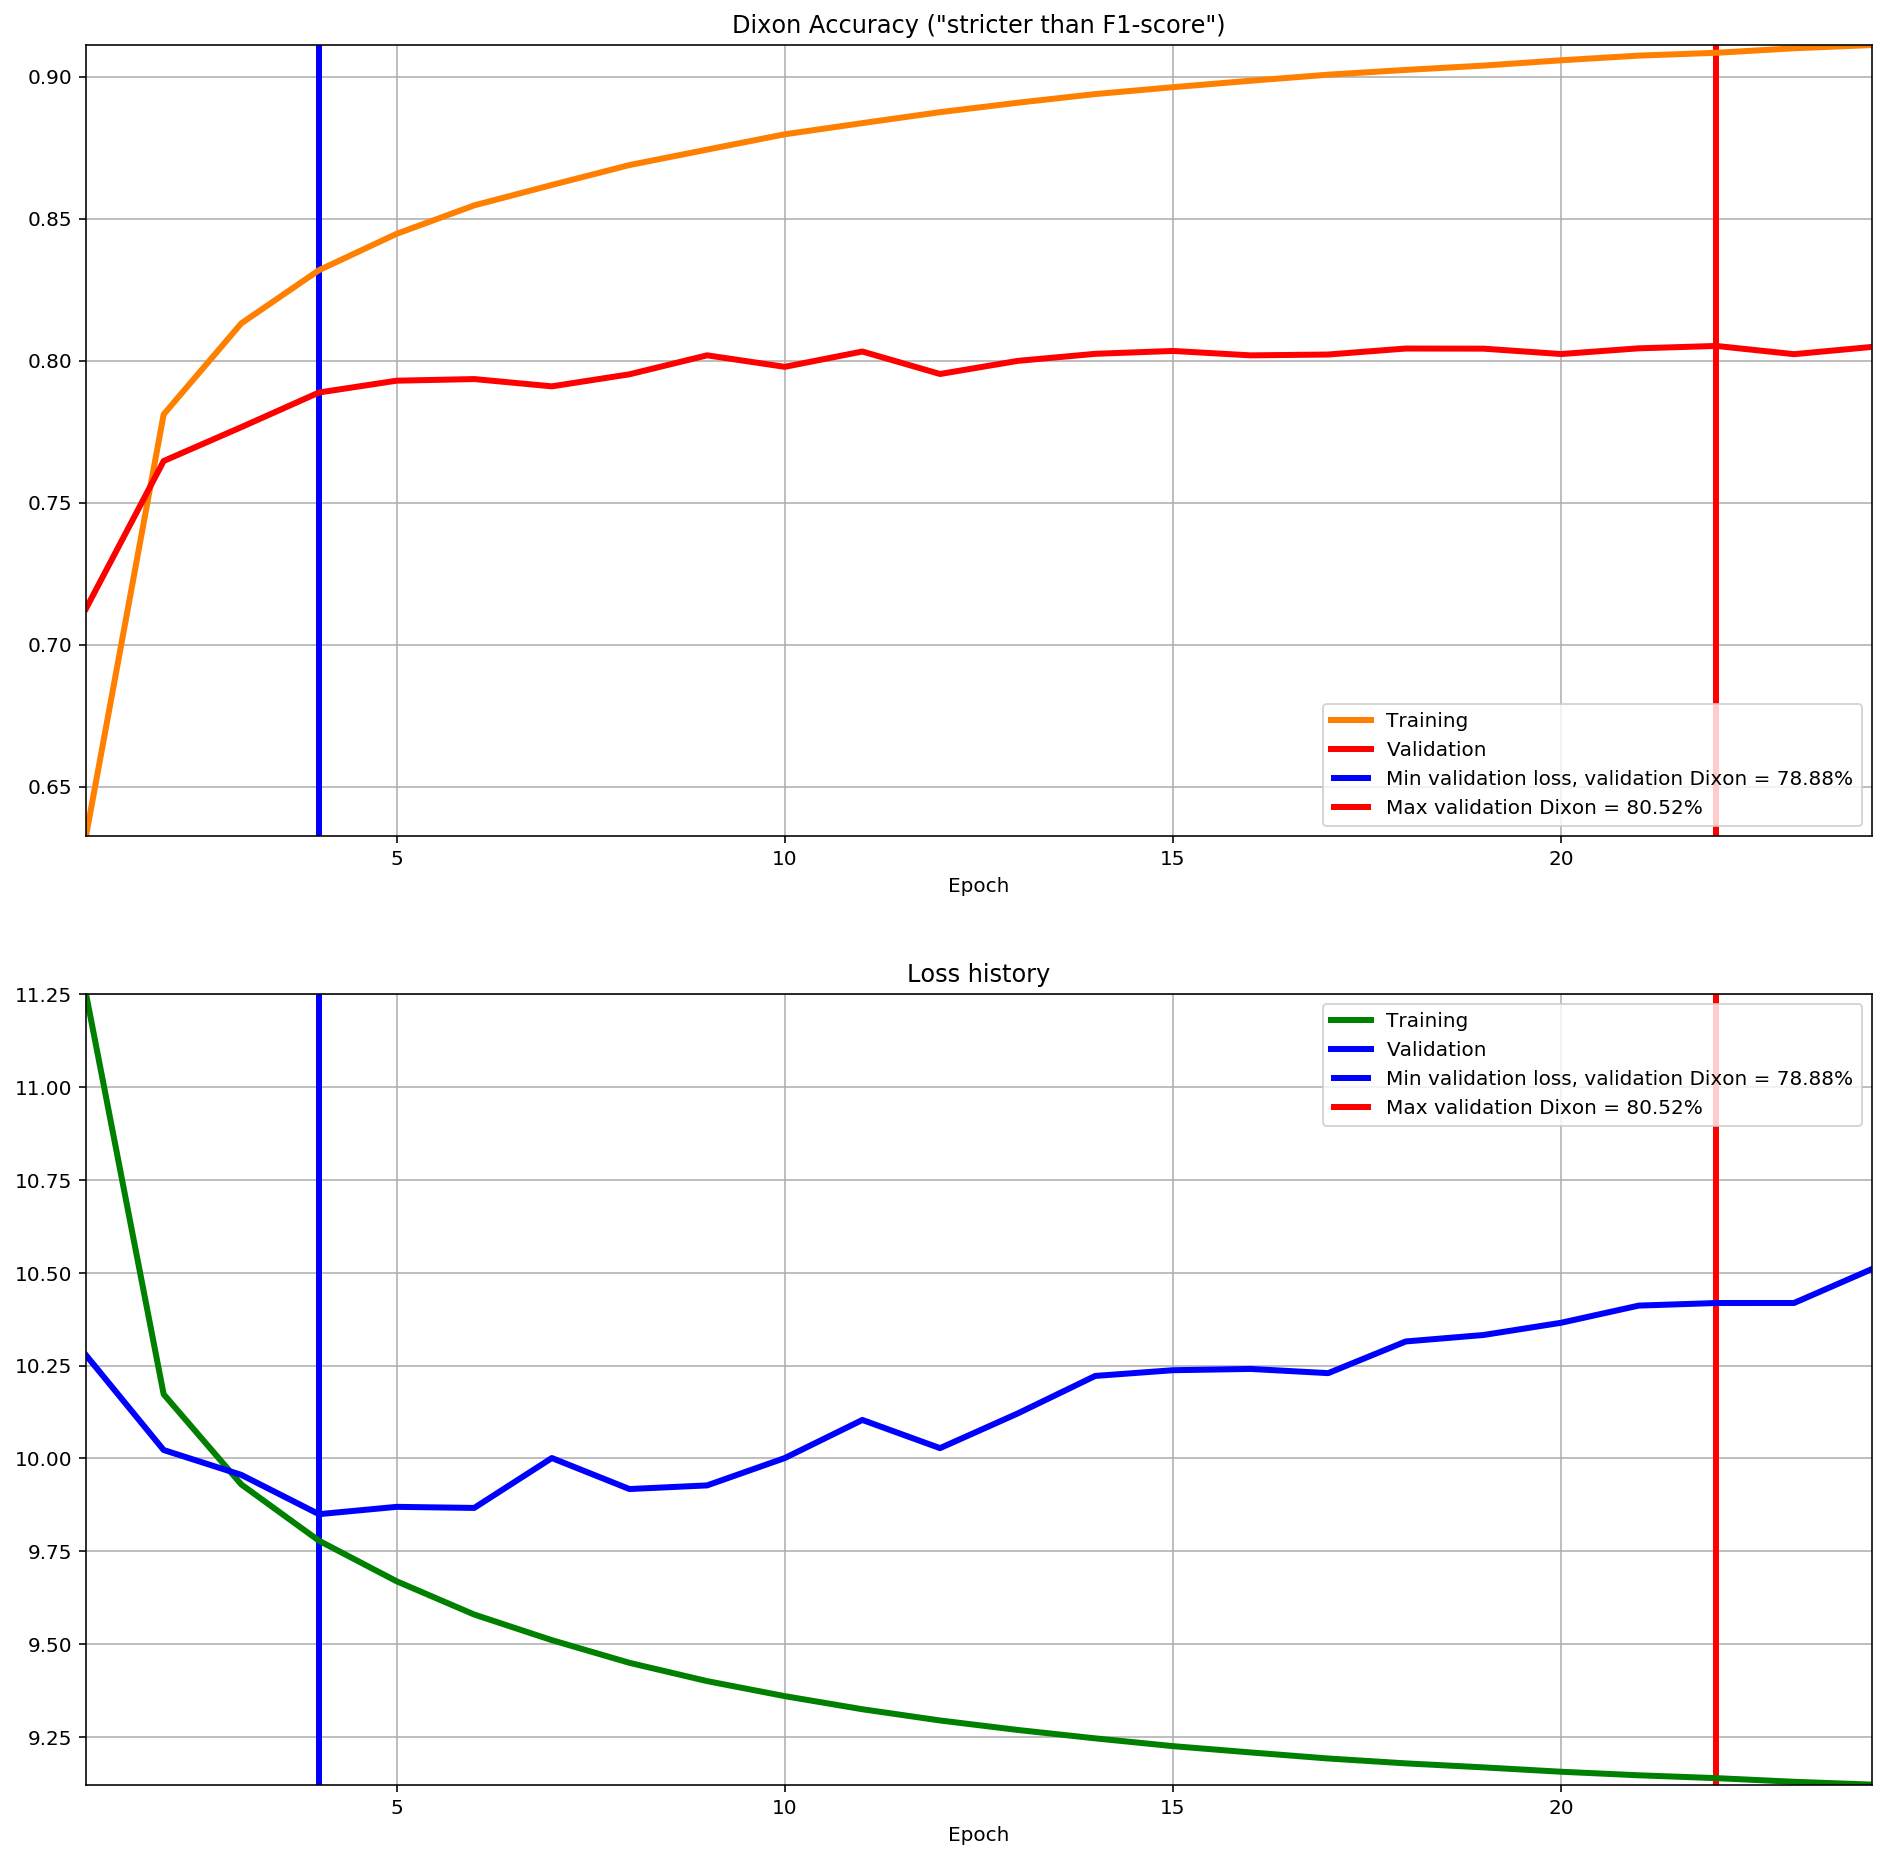

In [14]:
accTrain, accVal = HistoryGraph('Dixon', 'Dixon Accuracy ("stricter than F1-score")')

In [15]:
activesModel = load_model('{}/Training Actives Model {:.2f} {:.2f}.hdf5'.format(modelFolder, accTrain * 100, accVal * 100),
                          compile=False)

# Volumes CNN - separate network
From https://arxiv.org/pdf/1710.11153.pdf, Page 3, Section 3.1 "Velocity Estimation":

`We further extend the model by adding another stack to also predict velocities for each onset.  This stack is similar to the others and consists of the same layers of convolutions.  This stack does not connect to the other two.  The velocity labels are generated by dividing all the velocities by the maximum velocity present in the piece.  The smallest velocity does not go to zero, but rather to` $v_{min}$ __**...**__ $v_{max}$` .  The stack is trained with the following loss averaged across a batch:`
$$L_{vel} = \sum_{p=p_{min}}^{p_{max}}\sum_{t=0}^{T}I_{onset}(p, t)(v_{label}^{p, t} - v_{predicted}^{p, t})^2$$
`At inference time the output is clipped to [0, 1] and then transformed to a midi velocity by the following mapping:`
$$v_{midi} = 80v_{predicted} + 10$$

# Volumes Accuracy Metric
From https://arxiv.org/pdf/1710.11153.pdf, Page 3, Section 3.1 "Velocity Estimation":

`... we first re-scale all of the ground-truth velocities in a transcription to be in the range [0, 1].  After notes are matched according to their pitch and onset/offset timing, we assemble pairs of the reference (ground-truth) and estimated velocities for matched notes, referred to as` $v_r$ `and` $v_e$ `respectively.  We then perform a linear regression to estimate a global scale and offset parameter such that the squared difference between pairs of reference and estimated velocities is minimized:`

Page 4:
$$m, b = \underset{m, b}{argmin}\sum_{i=1}^{M}||v_r(i)-(mv_e(i) + b)||^2$$
`where` __**M**__ `is the number of matches (i.e. number of entries in` $v_r$ `and` $v_e$ `).  These scalar parameters are used to re-scale the entries of` $v_e$ `to obtain`
$$\hat{v_e} = \{mv_e(i) + b, i ∈ 1,...,M\}$$
`Finally, a match` __*i*__ `is now only considered correct if, in addition to having its pitch and timing match, it also satisfies` $|v_e(i) − v_r(i)| < τ$ `for some threshold` __**τ**__ `.  We used` __**τ**__ ` = 0.1 in all of our evaluations.  The precision, recall, and F1 scores are then recomputed as normal based on this newly filtered list of matches.`

In [16]:
volumesTrain, volumesVal = map(lambda split: np.load('{}/Volumes {}.npy'.format(dataFolder, split), 'r'),
                               ['train', 'validation'])
volsTrainMin,  volsValMin  = map(np.min,  [volumesTrain, volumesVal])
volsTrainMean, volsValMean = map(np.mean, [volumesTrain, volumesVal])
volsTrainMax,  volsValMax  = map(np.max,  [volumesTrain, volumesVal])
assert volsTrainMin == volsValMin == 0 and 0 < volsTrainMax <= 1 and 0 < volsValMax <= 1, 'Wrong normalized MIDI volumes range'
print('Midi normalized volumes in range [{} ... {:.4f} ... {:.2f}]'.format(
    min(volsTrainMin, volsValMin), np.mean([volsTrainMean, volsValMean]), max(volsTrainMax, volsValMax)))

Midi normalized volumes in range [0.0 ... 0.0033 ... 0.99]


Loading pre-trained Volumes model...
Spent 45 epochs, current validation loss and VolAcc are:
3088/3088 [==============================] - 54s 17ms/step
[1.5826892491918325e-05, 0.9619141807827924]


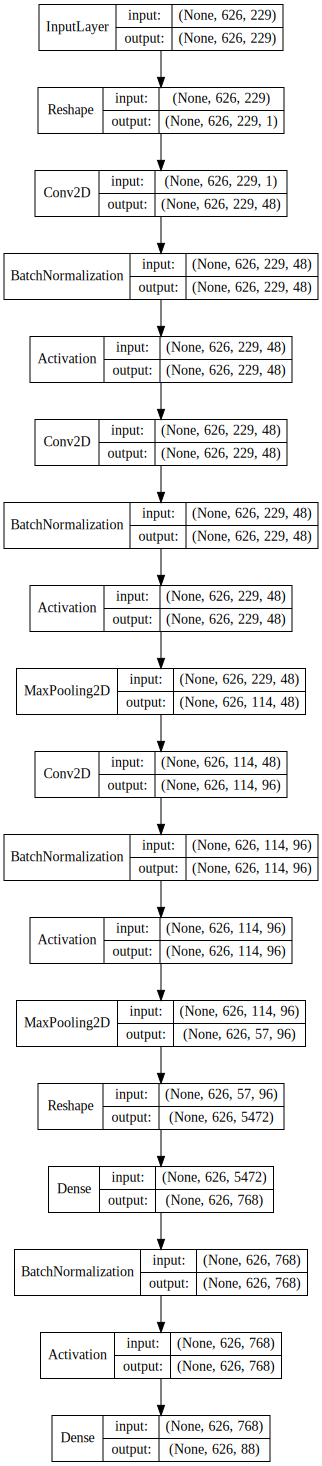

In [17]:
def VolAcc(yTrue, yPred):
    onsets = K.cast(yTrue > K.epsilon(), float)
    yPredOnsets, numNotes = yPred * onsets, K.sum(onsets)
    
    # Linear regression:
    sumX, sumY = map(K.sum, (yPredOnsets, yTrue))
    m = (numNotes * K.sum(yPredOnsets * yTrue) - sumX * sumY) / (numNotes * K.sum(yPredOnsets ** 2) - sumX ** 2)
    yPredOnsets = (m * yPredOnsets + (sumY - m * sumX) / numNotes) * onsets
    
    return (numNotes - K.sum(K.cast(K.abs(yPredOnsets - yTrue) > .1, float))) / numNotes

def VolLoss(yTrue, yPred): return mean_squared_error(yTrue, yPred * K.cast(yTrue > K.epsilon(), float))

model, hist = GetModel('Volumes', {'VolAcc': VolAcc}, 99.71 / 100, 96.57 / 100, melsVal, volumesVal, 32, False, VolLoss)
PlotModel()

In [19]:
TrainAndSave(melsTrain, melsVal, volumesTrain, volumesVal, 8, 'Volumes', 'VolAcc')

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
28346/28346 [==============================] - 1922s 68ms/step - loss: 5.2576e-06 - VolAcc: 0.9972 - val_VolAcc: 0.9650
Epoch 1/1
28346/28346 [==============================] - 1682s 59ms/step - loss: 5.3633e-06 - VolAcc: 0.9971 - val_VolAcc: 0.9657


Maximum validation VolAcc = 97.20%, but the chosen ones are at the minimum validation loss:
Train = 98.72%, Validation = 96.95%


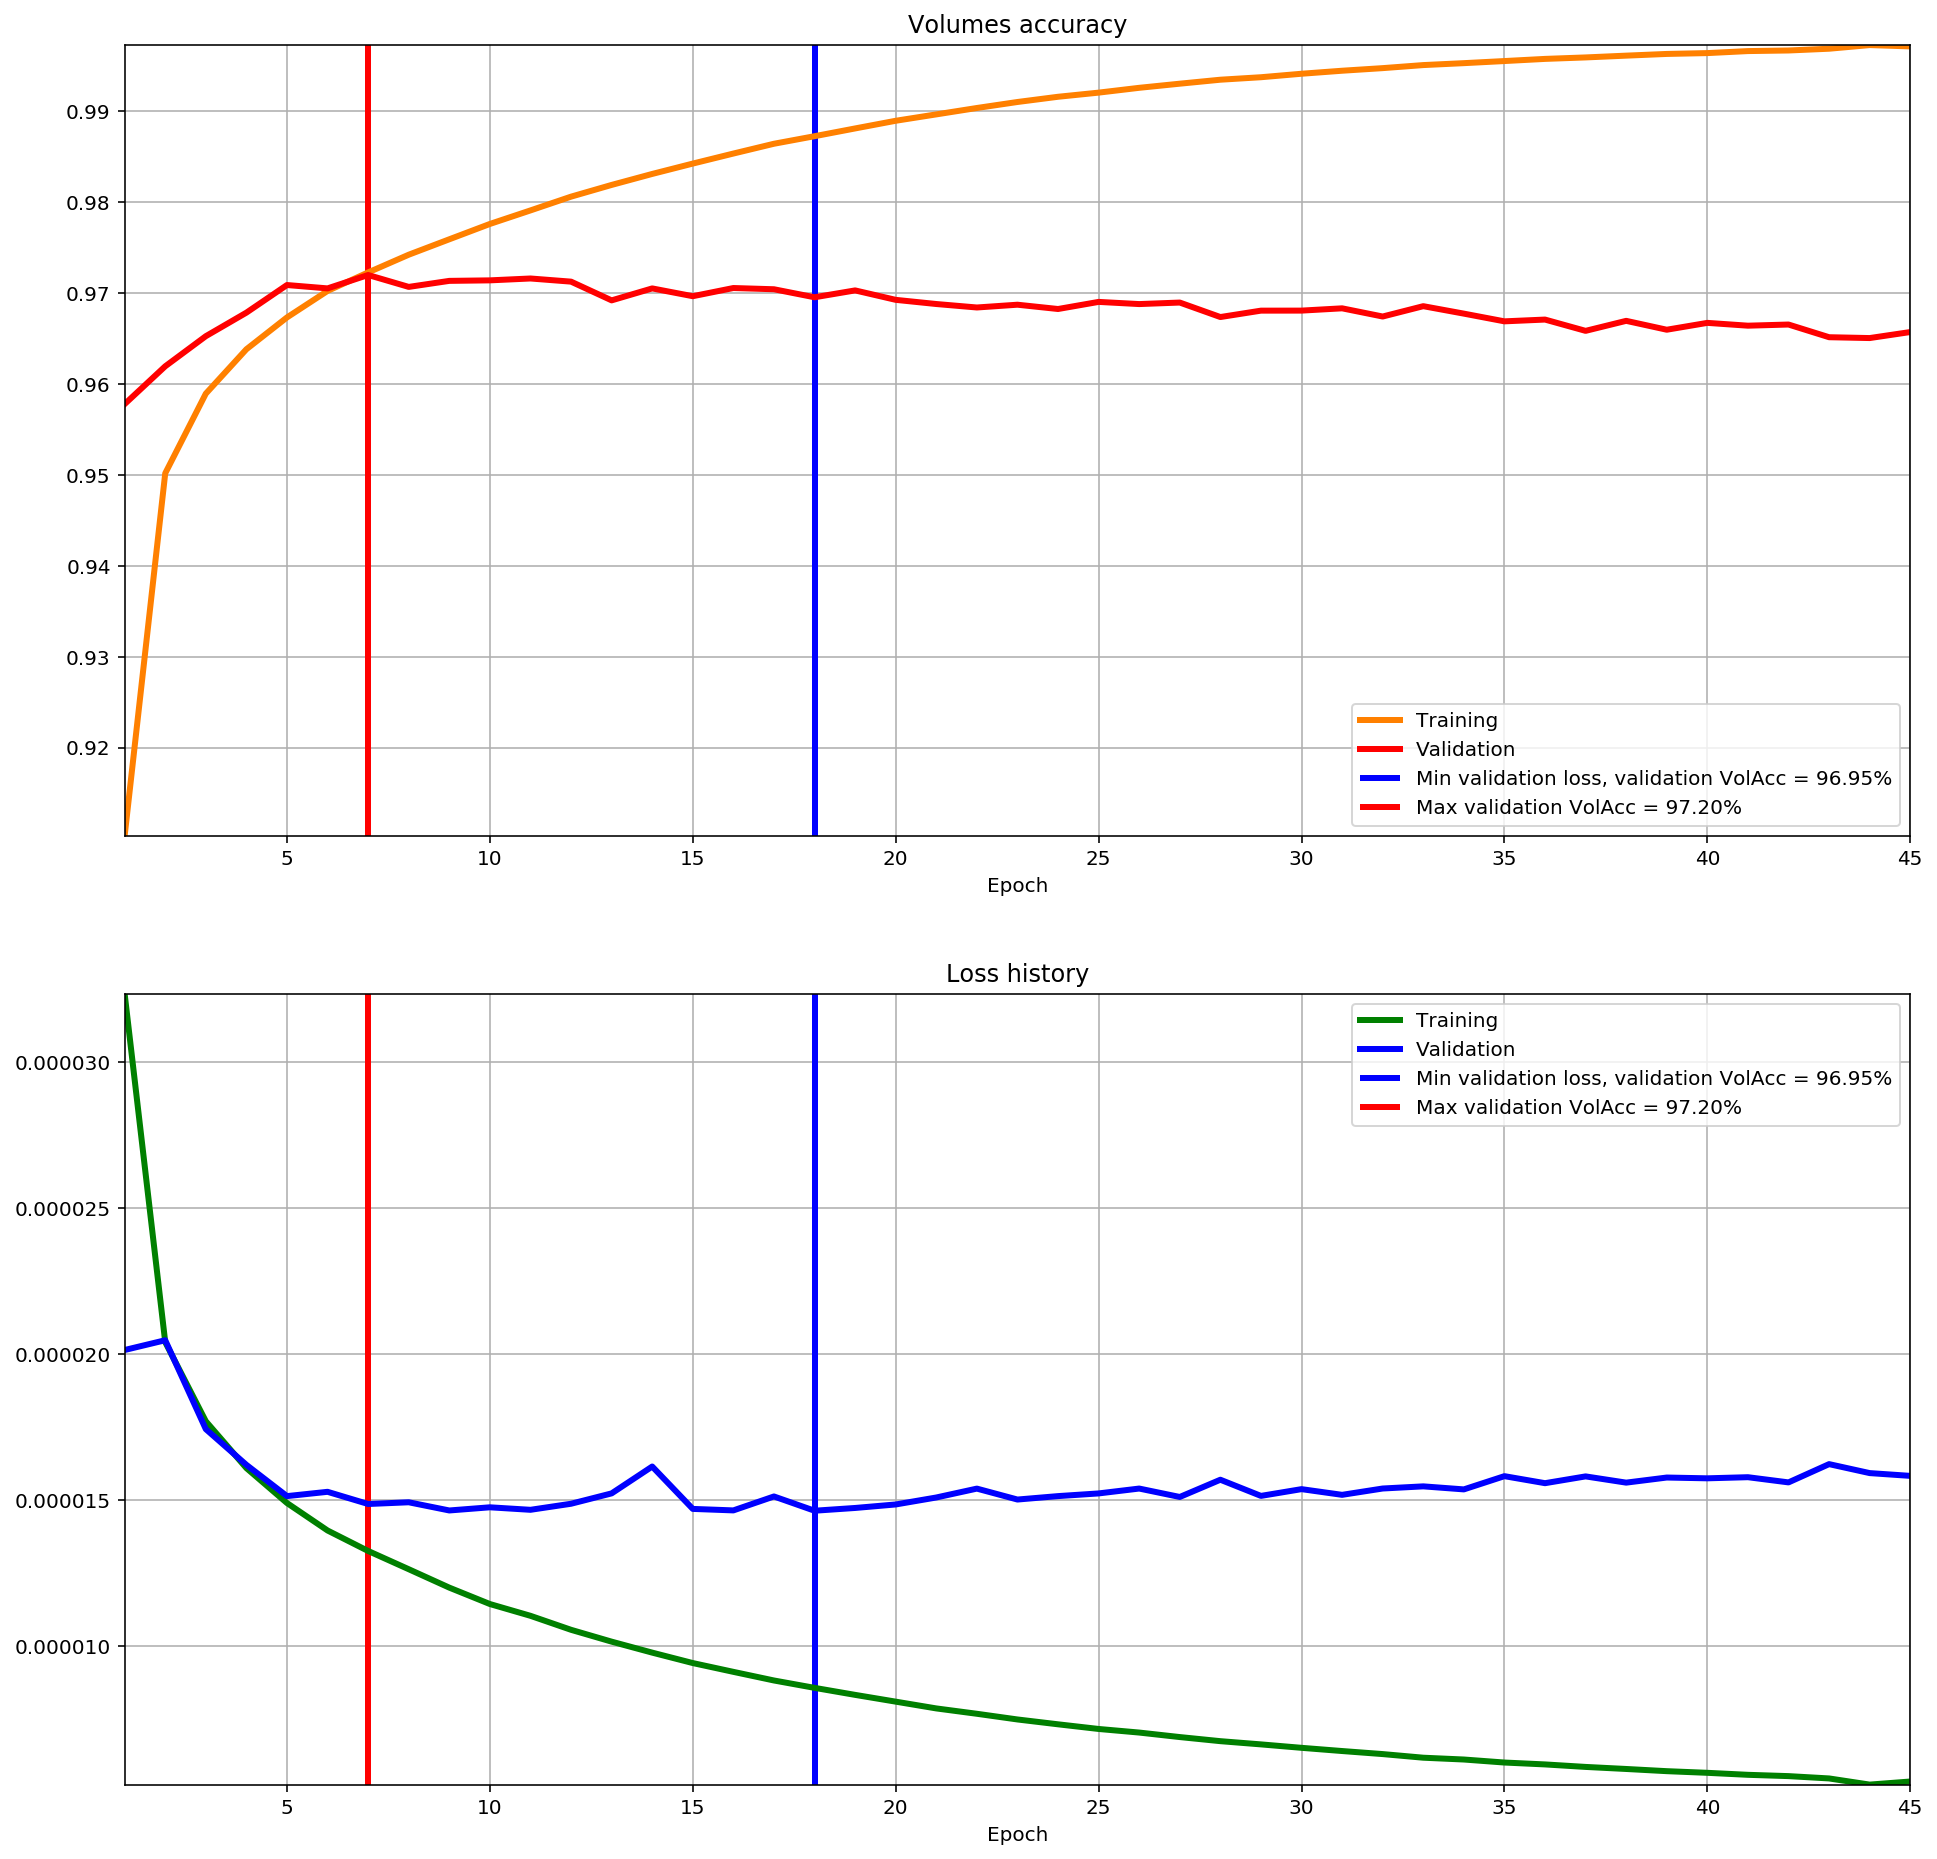

In [18]:
accTrain, accVal = HistoryGraph('VolAcc', 'Volumes accuracy')

In [19]:
volumesModel = load_model('{}/Training Volumes Model {:.2f} {:.2f}.hdf5'.format(modelFolder, accTrain * 100, accVal * 100),
                          compile=False)

# 2. Testing.
From https://arxiv.org/pdf/1710.11153.pdf, Page 2, Section 2 "Dataset and Metrics":

1. `We use the mir eval library ... to calculate notebased precision, recall, and F1 scores.`


2. `... we calculate two versions of note metrics: one requiring that onsets be within ±50ms of ground truth but ignoring offsets and one that also requires offsets resulting in note durations within 20% of the ground truth or within 50ms, whichever is greater.`


3. `Both frame and note scores are calculated per piece and the mean of these per-piece scores is presented as the final metric for a given collection of pieces.`


4. `Poor quality transcriptions can still result in high frame scores due to short spurious notes and repeated notes that should be held.`

Page 4, Section 4 "Experiments":

`To our ears, the decrease in transcription quality is best reflected by the note-with-offset scores.`

From https://arxiv.org/pdf/1810.12247.pdf, Page 5, Section 4 "Piano Transcription", Table 4:

`Note-based scores calculated by the mir eval library, frame-based scores as defined in Bay et al. (2009). Final metric is the mean of scores calculated per piece.`

In [ ]:
fps = 16_000 / 512
for mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue in zip(*(glob(
#        '{}/test/*{}.npy'.format(dataFolder, name)) for name in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])):
        'Maestro/1-5 seconds/test/*{}.npy'.format(name)) for name in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])):
    print(mels.split()[:-1])
    mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue = map(lambda arr: np.load(
#        'r', # ValueError: Array can't be memory-mapped: Python objects in dtype
        arr, allow_pickle=True), [mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue])
    
    ps, rs, f1s, offPs, offRs, offF1s, volsPs, volsRs, volsF1s = [], [], [], [], [], [], [], [], []
    onTrueAll, onPredAll, onProbAll, offProbAll, actProbAll, volProbAll = None, None, [], [], [], []
    for i, [m, onTrue, offTrue, actTrue, volTrue] in enumerate(zip(mels, onsetsTrue, offsetsTrue, activesTrue, volumesTrue)):
        print('\t{} of {}'.format(i + 1, len(onsetsTrue)))

        m, onTrue, offTrue, actTrue, volTrue = map(np.array, [m, onTrue, offTrue, actTrue, volTrue])
        refIntervals, refPitches, refVolumes = sequence_to_valued_intervals(pianoroll_to_note_sequence(
            actTrue, fps, 0, onset_predictions=onTrue, offset_predictions=offTrue, velocity_values=volTrue), 0)

        m = np.pad(m, [(0, -len(m) % melsVal.shape[1]), (0, 0)], 'minimum').reshape((-1, melsVal.shape[1], melsVal.shape[2]))
        onProb, offProb, volProb = map(lambda mod: mod.predict(m, 32, 1), [onsetsModel, offsetsModel, volumesModel])
        actProb = activesModel.predict([m, onProb, offProb], 32, 1)

        onProb, offProb, actProb, volProb = map(lambda arr: np.vstack(
            arr)[:len(actTrue)], [onProb, offProb, actProb, volProb])
        onPred, offPred, actPred = map(lambda arr: binarize(arr, .5), [onProb, offProb, actProb])
        onTrueAll, onPredAll = map(lambda arr, newArr: newArr if arr is None else
            np.vstack([arr, newArr]), [onTrueAll, onPredAll], [onTrue, onPred])

        estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(pianoroll_to_note_sequence(
            actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb), 0)
        refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])

        p, r, f1, offP, offR, offF1, volsP, volsR, volsF1 = Overlap(refIntervals, refPitches, estIntervals, estPitches,
                                  offset_ratio=None)[:-1] + Overlap(refIntervals, refPitches, estIntervals, estPitches)[:-1] \
                           + OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[:-1]
        ps, rs, f1s, offPs, offRs, offF1s, volsPs, volsRs, volsF1s = ps + [p], rs + [r], f1s + [f1], \
            offPs + [offP], offRs + [offR], offF1s + [offF1], volsPs + [volsP], volsRs + [volsR], volsF1s + [volsF1]
    
    print('\nOnsets: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
            'Frames: \nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n\n'
            'Volumes:\nPrecision (specificity) = {:.2%}\nRecall    (sensitivity) = {:.2%}\nF1-score                = {:.2%}\n'
          .format(np.mean(ps), np.mean(rs), np.mean(f1s), np.mean(offPs), np.mean(offRs), np.mean(offF1s),
                  np.mean(volsPs), np.mean(volsRs), np.mean(volsF1s)))

    numOnsetsTrue, numOnsetsPred = map(lambda arr: arr.sum(1), [onTrueAll, onPredAll])
    numOnsetsTrue, numOnsetsPred = map(lambda arr: arr.sum() / len(np.nonzero(arr)[0]), [numOnsetsTrue, numOnsetsPred])
    print('Actual and predicted average number of onsets: {:.2f} {:.2f}'.format(numOnsetsTrue, numOnsetsPred))
    print('Predicts',                'more' if numOnsetsPred > numOnsetsTrue else 'less',
          'notes than actual', '(sensitive' if numOnsetsPred > numOnsetsTrue else '(specific', 'classifier)\n')
    assert abs(numOnsetsTrue - numOnsetsPred) < .1

2004
	1 of 9


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 9


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 9


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 9


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 9


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 9


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 9


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 9


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 9


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 77.61%
Recall    (sensitivity) = 86.39%
F1-score                = 81.18%

Frames: 
Precision (specificity) = 53.27%
Recall    (sensitivity) = 58.21%
F1-score                = 55.31%

Volumes:
Precision (specificity) = 51.94%
Recall    (sensitivity) = 56.76%
F1-score                = 53.93%

Actual and predicted average number of onsets: 1.71 1.68
Predicts less notes than actual (specific classifier)

2006
	1 of 11


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 11


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 11


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 11


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 11


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 11


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 11


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 11


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 11


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 11


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	11 of 11


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 75.56%
Recall    (sensitivity) = 84.59%
F1-score                = 79.52%

Frames: 
Precision (specificity) = 49.64%
Recall    (sensitivity) = 55.06%
F1-score                = 52.02%

Volumes:
Precision (specificity) = 47.91%
Recall    (sensitivity) = 53.04%
F1-score                = 50.17%

Actual and predicted average number of onsets: 1.75 1.71
Predicts less notes than actual (specific classifier)

2008
	1 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	11 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	12 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	13 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	14 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	15 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	16 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	17 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	18 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	19 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	20 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	21 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	22 of 22


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 76.81%
Recall    (sensitivity) = 85.52%
F1-score                = 80.07%

Frames: 
Precision (specificity) = 53.08%
Recall    (sensitivity) = 58.00%
F1-score                = 54.96%

Volumes:
Precision (specificity) = 51.76%
Recall    (sensitivity) = 56.55%
F1-score                = 53.59%

Actual and predicted average number of onsets: 1.77 1.70
Predicts less notes than actual (specific classifier)

2009
	1 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	11 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	12 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	13 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	14 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	15 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	16 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	17 of 17


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 81.58%
Recall    (sensitivity) = 88.64%
F1-score                = 84.70%

Frames: 
Precision (specificity) = 55.66%
Recall    (sensitivity) = 59.59%
F1-score                = 57.39%

Volumes:
Precision (specificity) = 53.93%
Recall    (sensitivity) = 57.75%
F1-score                = 55.61%

Actual and predicted average number of onsets: 1.60 1.58
Predicts less notes than actual (specific classifier)

2011
	1 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	11 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	12 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	13 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	14 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	15 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	16 of 16


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 82.69%
Recall    (sensitivity) = 88.73%
F1-score                = 85.43%

Frames: 
Precision (specificity) = 61.56%
Recall    (sensitivity) = 65.61%
F1-score                = 63.40%

Volumes:
Precision (specificity) = 60.10%
Recall    (sensitivity) = 64.04%
F1-score                = 61.89%

Actual and predicted average number of onsets: 1.84 1.77
Predicts less notes than actual (specific classifier)

2013
	1 of 10


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	2 of 10


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	3 of 10


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	4 of 10


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	5 of 10


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	6 of 10


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	7 of 10


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	8 of 10


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	9 of 10


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


	10 of 10


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]



Onsets: 
Precision (specificity) = 78.18%
Recall    (sensitivity) = 85.23%
F1-score                = 81.44%

Frames: 
Precision (specificity) = 57.76%
Recall    (sensitivity) = 62.88%
F1-score                = 60.13%

Volumes:
Precision (specificity) = 56.12%
Recall    (sensitivity) = 61.08%
F1-score                = 58.42%

Actual and predicted average number of onsets: 2.03 1.95
Predicts less notes than actual (specific classifier)

2014


82/82 [==============================] - 3s 38ms/step


C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the 

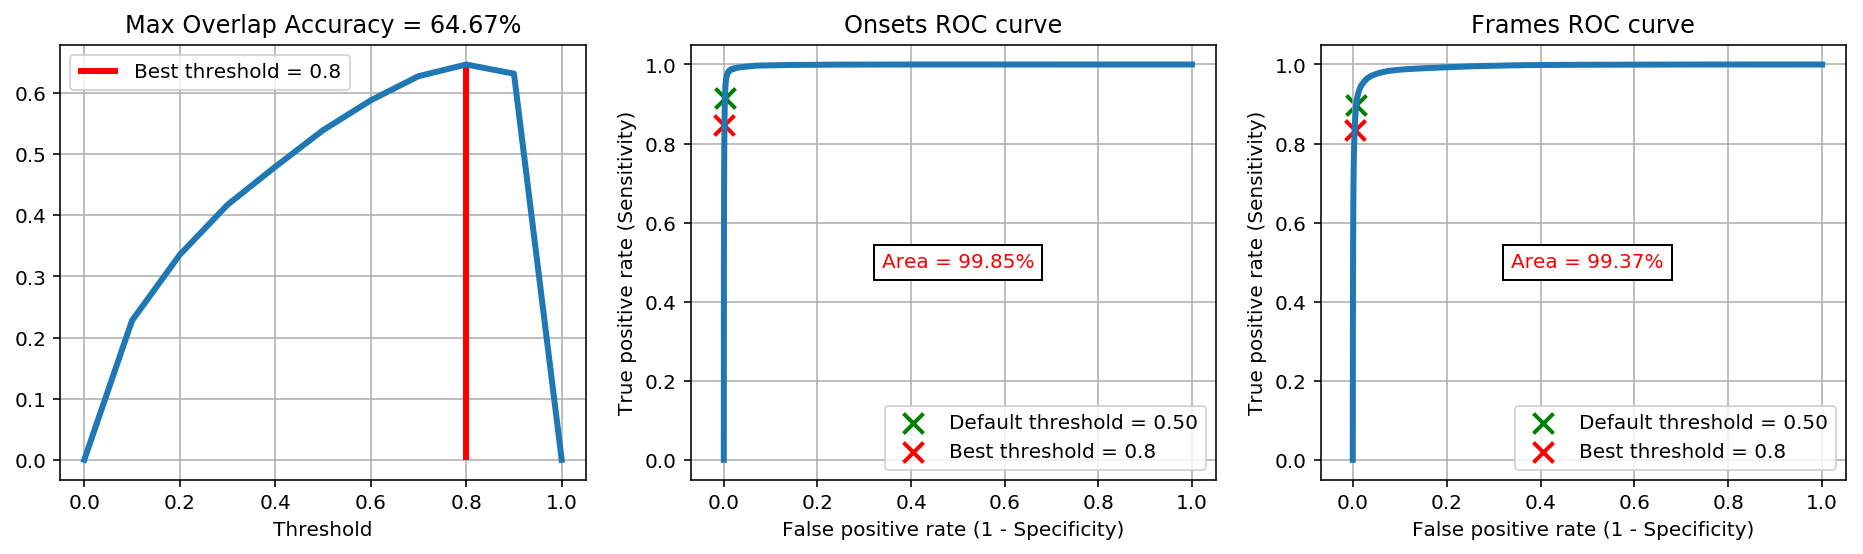

In [38]:
mels2014, onTrue2014, offTrue2014, actTrue2014, volTrue2014 = map(lambda name: np.vstack(np.load(
#    '{}/test/2014/MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--2 {}.npy'.format(dataFolder, name),
    'Maestro/1-5 seconds/test/2014/MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_20_R1_2014_wav--2 {}.npy'.format(name),
    'r', allow_pickle=True)), ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'])

mels2014 = np.pad(mels2014, [(0, -len(mels2014) % melsVal.shape[1]), (0, 0)],
                  'minimum').reshape((-1, melsVal.shape[1], melsVal.shape[2]))
onProb2014, offProb2014, volProb2014 = map(lambda mod: mod.predict(mels2014, 16, 1), [
    load_model( '{}/Training Onsets Model 63.98 64.00.hdf5'.format(modelFolder), compile=False),
    load_model('{}/Training Offsets Model 43.21 39.53.hdf5'.format(modelFolder), compile=False),
    load_model('{}/Training Volumes Model 98.72 96.95.hdf5'.format(modelFolder), compile=False)])
actProb2014 = load_model('{}/Training Actives Model 83.18 78.88.hdf5'.format(modelFolder),
                         compile=False).predict([mels2014, onProb2014, offProb2014], 16, 1)
onProb2014, offProb2014, actProb2014, volProb2014 = map(lambda arr: np.vstack(
    arr)[:len(actTrue2014)], [onProb2014, offProb2014, actProb2014, volProb2014])

def VolumesF1(onPred, offPred, actPred):
    refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes = sequence_to_valued_intervals(
        pianoroll_to_note_sequence(actTrue2014, fps, 0, onset_predictions=onTrue2014, offset_predictions=offTrue2014,
            velocity_values=volTrue2014), 0) + sequence_to_valued_intervals(pianoroll_to_note_sequence(
        actPred, fps, 0, onset_predictions=onPred, offset_predictions=offPred, velocity_values=volProb2014), 0)
    refPitches, estPitches = map(lambda ps: midi_to_hz(ps + 21), [refPitches, estPitches])
    return OverlapVolumes(refIntervals, refPitches, refVolumes, estIntervals, estPitches, estVolumes)[2]


precision = 10
th = [i / precision for i in range(precision + 1)]
acc = [0] + [VolumesF1(*map(lambda arr: binarize(arr, t), [onProb2014, offProb2014, actProb2014])) for t in th[1:]]

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)

plt.plot(th, acc, linewidth=3)
plt.title('Max Overlap Accuracy = {:.2%}'.format(max(acc)))
plt.xlabel('Threshold')

thBest = acc.index(max(acc)) / precision
plt.vlines(thBest, 0, max(acc), 'r', label='Best threshold = ' + str(thBest), linewidth=3)

plt.legend()
plt.grid()

def PlotROC(i, yTrue, yProb, name):
    plt.subplot(1, 3, i)

    fpr, tpr, ths = roc_curve(yTrue.ravel(), yProb.ravel()) # micro-average ROC curve
    plt.plot(fpr, tpr, linewidth = 3)

    plt.title(name + ' ROC curve')
    plt.xlabel('False positive rate (1 - Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')

    plt.scatter(fpr[ths > .5][-1], tpr[ths > .5][-1], s=100, c='g', marker='x',
                linewidth=2, label='Default threshold = 0.50')
    plt.scatter(fpr[ths > thBest][-1], tpr[ths > thBest][-1], s=100, c='r', marker='x',
                linewidth=2, label='Best threshold = ' + str(thBest))

    plt.legend()
    plt.grid()
    plt.text(.5, .5, 'Area = {:.2%}'.format(auc(fpr, tpr)), horizontalalignment='center', verticalalignment='center',
             bbox={'facecolor': 'w', 'alpha': 1}, color='r'); # micro-average area under the ROC curve

PlotROC(2,  onTrue2014,  onProb2014, 'Onsets')
PlotROC(3, actTrue2014, actProb2014, 'Frames')

C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]
C:\Users\Evgeniy\Anaconda3\lib\site-packages\mir_eval\transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ref_matched_velocities)[0]


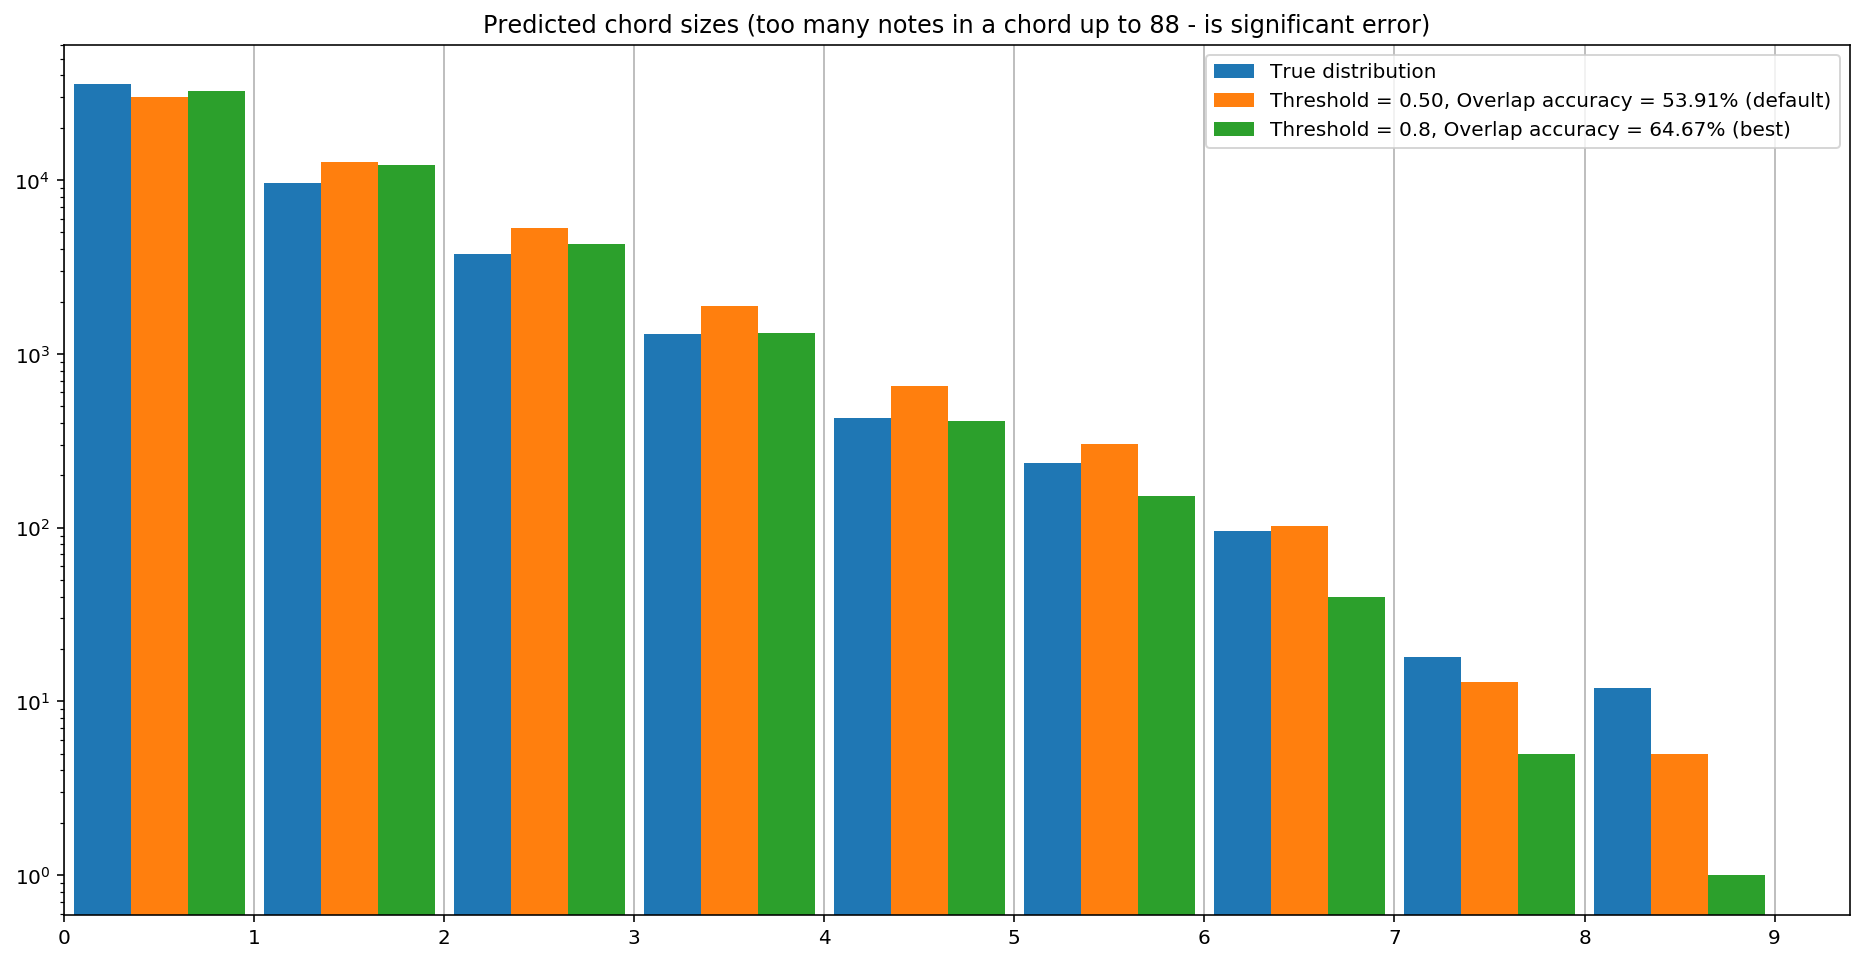

In [56]:
yPresize, yDefault = map(lambda t: binarize(onProb2014, t).astype(int), [thBest, .5])
counts = [onTrue2014.sum(1), yDefault.sum(1), yPresize.sum(1)]
maxCount = int(np.max(counts))

plt.figure(figsize=(16, 8))
plt.hist(counts, maxCount, rwidth=.9, log=True, label=['True distribution',
    'Threshold = 0.5, Overlap accuracy = {:.2%} (default)'.format(        VolumesF1(
          yDefault, binarize(offProb2014, .5),     binarize(actProb2014, .5))),
      'Threshold = {}, Overlap accuracy = {:.2%} (best)'  .format(thBest, VolumesF1(
          yPresize, binarize(offProb2014, thBest), binarize(actProb2014, thBest)))])

plt.title('Predicted chord sizes (too many notes in a chord up to 88 - is significant error)')
plt.xlim(0)
plt.xticks(range(maxCount + 1))
plt.grid(axis='x')
plt.legend();